$$\Large \textit{C0708 | Reconocimiento de Patrones}$$

$$\large \textbf{Challenge Nº8 | Redes neuronales recurrentes (LSTM)}$$


_Integrantes:_

* _José Cebrián Baca_

* _Ana Lucia Manrique De La Torre_

* _Willy Valdivia_

La LSTM (Long Short-Term Memory) es una arquitectura de red neuronal recurrente (RNN), que se utiliza para modelar y predecir secuencias de datos. Debido a su capacidad para modelar con mayor precisión secuencias temporales y las relaciones de largo alcance entre ellas, las LSTM se han convertido en una técnica muy popular para la clasificación de texto en comparación con las RNN convencionales y otras técnicas de aprendizaje automático [1]. Con el objetivo de describir adecuadamente su funcionamiento es necesario entender en primer lugar el funcionamiento de una RNN.
A diferencia de una red neuronal tradicional (NN), donde se asume que las entradas y salidas son independientes, las RNN se han desarrollado con el objetivo de realizar una serie de tareas en las que el resultado obtenido es utilizado como entrada del siguiente [1]. Una RNN simple se muestra en la siguiente figura:


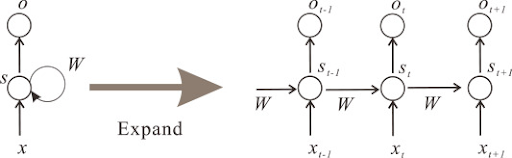

Figura 1. Diagrama de RNN simple. Xt y Ot se plantean como entrada y salida en el tiempo respectivamente. El estado oculto St se calcula en función del estado oculto anterior St-1 y se comporta como entrada al estado actual. Fuente: [1]

Un problema común de este tipo de red neuronal es la gradiente decreciente [2], la cual hace que el nodo oculto se aproxime a cero a medida que el intervalo de tiempo crece. De esta manera, las RNN disminuyen su efectividad para el modelado de series temporales a largo plazo [2]. Con el objetivo de abordar este problema, se diseñaron las LSTM las cuales reemplazaron la unidad oculta recurrente con una celda de memoria [2]. Cada celda de memoria tiene tres compuertas principales: la puerta de entrada, la puerta de olvido y la puerta de salida. La arquitectura de red LSTM consta de tres partes, como se muestra en la imagen a continuación, y cada parte realiza una función individual: [3]


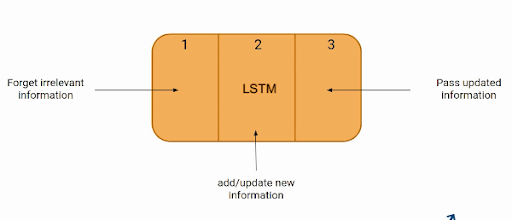

Figura 2. Estructura de un LSTM. Fuente: [3]

La primera etapa implica la decisión de retener o descartar la información previa de la marca de tiempo anterior. En la segunda etapa, la celda busca asimilar nueva información proveniente de la entrada actual. Finalmente, en la tercera etapa, la celda transfiere la información actualizada de la marca de tiempo actual a la siguiente. Este proceso de las LSTM se conoce como un paso individual [3]. Estas tres etapas son las denominadas puertas antes mencionadas (la puerta de entrada, la puerta de olvido y la puerta de salida respectivamente).
De la misma forma que un RNN simple, un LSTM también tiene un estado oculto donde H(t-1) representa el estado oculto de la marca de tiempo anterior y Ht es el estado oculto de la marca de tiempo actual. Además de eso, LSTM también tiene un estado de celda representado por C(t-1) y C(t) para las marcas de tiempo anterior y actual, respectivamente. Aquí, el estado oculto se conoce como memoria a corto plazo y el estado de celda se conoce como memoria a largo plazo. De esta forma, se obtiene el siguiente diagrama [3]:


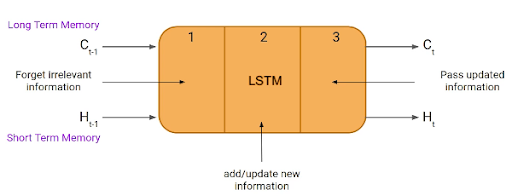

Figura 3. Estructura de un LSTM. Fuente: [3]

En el contexto del trabajo actual, se ha observado que las moléculas químicas se pueden representar como secuencias de caracteres (SMILES), donde el orden de los caracteres es crucial para capturar la estructura y las propiedades químicas. Las redes LSTM son especialmente adecuadas para modelar secuencias, ya que pueden aprender dependencias a largo plazo y capturar patrones complejos en los datos. De este modo, el modelo entrenado por esta red neuronal sería capaz de generar nuevas moléculas a partir del espacio latente aprendido y así generar moléculas que tengan una gran afinidad por la proteasa principal del SARS-CoV-2.

A continuación, se presenta la metodología seguida para el desarrollo de este notebook.

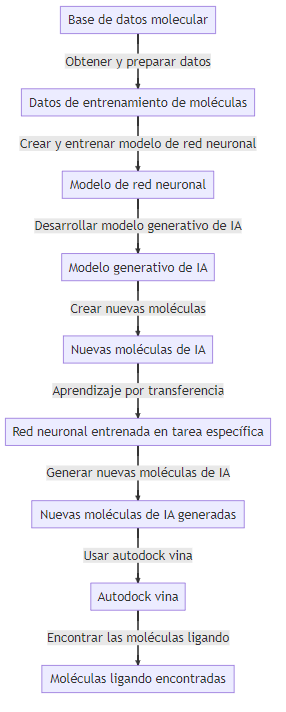

# 0. Requerimientos

In [ ]:
!git clone https://github.com/BLarzalere/AI-De-Novo-Molecule-Design.git

Cloning into 'AI-De-Novo-Molecule-Design'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 173 (delta 39), reused 65 (delta 33), pack-reused 100
Receiving objects: 100% (173/173), 30.57 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [ ]:
# Install RDKit.
%%capture
!pip install rdkit

In [ ]:
#no va
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

In [ ]:
# Importar core libraries
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

In [ ]:
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.12.0


In [ ]:
# Cargar Keras libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [ ]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sun Jul  2 01:20:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |    387MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

# 1. LSTM

In [ ]:
# Crear las funciones para el cargado de datos
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict

In [ ]:
!ls

AI-De-Novo-Molecule-Design  sample_data


In [ ]:
# Cargar el dataset y separar los datos de train/test
smifile = '/content/AI-De-Novo-Molecule-Design/Data/smiles_cleaned.smi'
data = load_data(smifile)
seed = 777
full_train, test = train_test_split(data, test_size=0.2, random_state=seed)
print("Training smiles shape:", full_train.shape)
print("Test smiles shape:", test.shape)
print("Sample training smile: \n", full_train[2])

Training smiles shape: (351278,)
Test smiles shape: (87820,)
Sample training smile: 
 Cc1cc(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)ccc1F


In [ ]:
data.shape

(439098,)

In [ ]:
# create our validation dataset
val_split = 0.10
train, val_set = train_test_split(full_train, test_size=val_split, random_state=seed)
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", val_set.shape)

Training dataset shape: (316150,)
Validation dataset shape: (35128,)


In [ ]:
# load the Python dictionaries that map characters-to-integers and intergers-to-characters
d1 = '/content/AI-De-Novo-Molecule-Design/Data/char_to_int.json'
d2 = '/content/AI-De-Novo-Molecule-Design/Data/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

In [ ]:
# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers,
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our X & y datasets
embed = 101
X_train, y_train = vectorize(train, embed, n_vocab)
X_val, y_val = vectorize(val_set, embed, n_vocab)
X_test, y_test = vectorize(test, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)
print("Validation input shape:", X_val.shape)
print("Validation output shape:", y_val.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)

Training input shape: (316150, 100, 45)
Training output shape: (316150, 100, 45)
Validation input shape: (35128, 100, 45)
Validation output shape: (35128, 100, 45)
Test input shape: (87820, 100, 45)
Test output shape: (87820, 100, 45)


In [ ]:
"".join([int_to_char[str(idx)] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!O=c1ccc(OCCCN2CCN(c3csc4ccccc34)CC2)nn1-c1ccc(Cl)c(Cl)c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [ ]:
# define the LSTM Chem model
def lstm_model(X, y):
    # define the encoder layers
    enc_input = Input(shape=(X.shape[1:]))
    _, state_h, state_c = LSTM(256, return_state=True)(enc_input)
    states = Concatenate(axis=-1)([state_h, state_c])
    bottle_neck = Dense(128, activation='relu')(states)

    # define the decoder layers
    state_h_decoded = Dense(256, activation='relu')(bottle_neck)
    state_c_decoded = Dense(256, activation='relu')(bottle_neck)
    encoder_states = [state_h_decoded, state_c_decoded]
    dec_input = Input(shape=(X.shape[1:]))
    dec1 = LSTM(256, return_sequences=True)(dec_input, initial_state=encoder_states)
    output = Dense(y.shape[2], activation='softmax')(dec1)

    model = Model(inputs=[enc_input, dec_input], outputs=output)
    return model

In [ ]:
# instantiate our neural network model
model = lstm_model(X_train, y_train)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [ ]:
# compile the model
batch_size = 256
steps_per_epoch = len(X_train) // batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=steps_per_epoch*50, decay_rate=1.0, staircase=False)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# compile the model
batch_size = 256
steps_per_epoch = len(X_train) // batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=steps_per_epoch*50, decay_rate=1.0, staircase=False)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# define our data sequence generator class
class Data_Generator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))

    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x, batch_y = np.array(x), np.array(y)

        return [batch_x, batch_x], batch_y

In [ ]:
# create object instances of our sequence generator
training_generator = Data_Generator(X_train, y_train, batch_size)
validation_generator = Data_Generator(X_val, y_val, batch_size)

In [ ]:
# # create our callbacks
file="/content/AI-De-Novo-Molecule-Design/Data/LSTM_Chem_weights-{epoch:02d}-{acc:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
tb = TensorBoard(log_dir="/drive/My Drive/logs/chem/", histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# fit the model
nb_epochs = 20
validation_steps = len(X_val) // batch_size
history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epochs, verbose=1,
                              validation_data=validation_generator, validation_steps=validation_steps,
                             use_multiprocessing=False, shuffle=True, callbacks=[])

Epoch 1/20
1234/1234 [==============================] - 72s 46ms/step - loss: 0.7790 - acc: 0.7569 - val_loss: 0.5497 - val_acc: 0.8169
Epoch 2/20
1234/1234 [==============================] - 58s 47ms/step - loss: 0.4992 - acc: 0.8311 - val_loss: 0.4613 - val_acc: 0.8425
Epoch 3/20
1234/1234 [==============================] - 59s 48ms/step - loss: 0.4410 - acc: 0.8477 - val_loss: 0.4206 - val_acc: 0.8541
Epoch 4/20
1234/1234 [==============================] - 59s 47ms/step - loss: 0.4088 - acc: 0.8574 - val_loss: 0.3948 - val_acc: 0.8619
Epoch 5/20
1234/1234 [==============================] - 59s 48ms/step - loss: 0.3890 - acc: 0.8635 - val_loss: 0.3776 - val_acc: 0.8673
Epoch 6/20
1234/1234 [==============================] - 59s 47ms/step - loss: 0.3723 - acc: 0.8689 - val_loss: 0.3649 - val_acc: 0.8714
Epoch 7/20
1234/1234 [==============================] - 59s 48ms/step - loss: 0.3601 - acc: 0.8729 - val_loss: 0.3535 - val_acc: 0.8751
Epoch 8/20
1234/1234 [==========================

# 2. Output

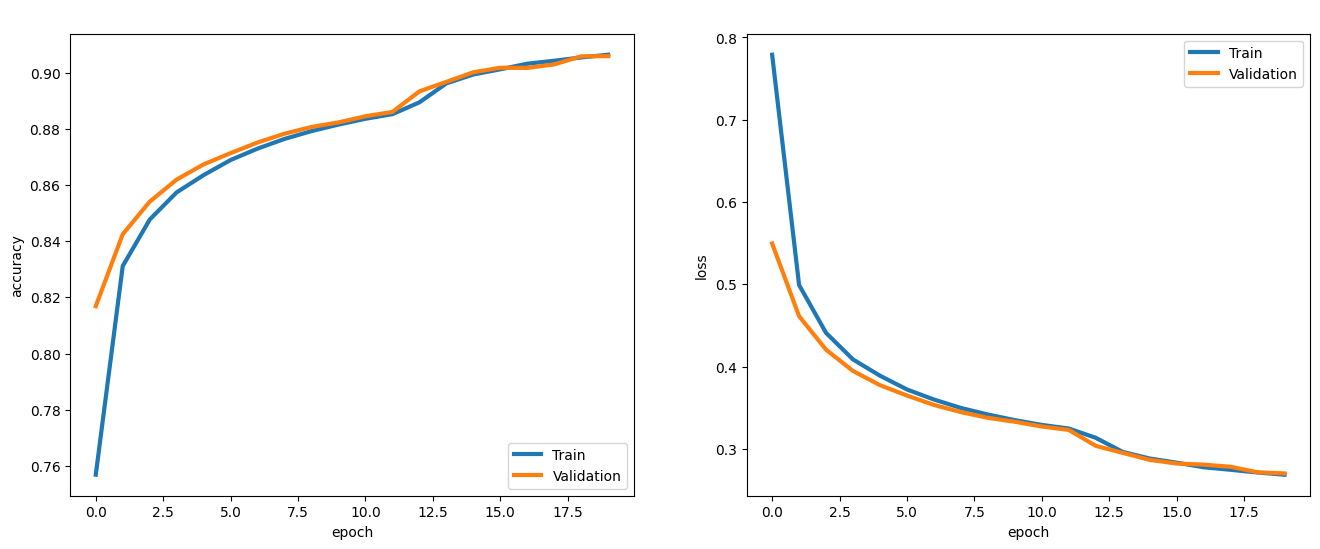

In [ ]:
# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history["acc"], label='Train', linewidth=3)
axis1.plot(history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16, color="white")
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history.history["loss"], label='Train', linewidth=3)
axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16, color="white")
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

Nota: Tener en cuenta que solamente se ejecutaron 20 epochs

In [ ]:
# evaluate our test set
score, acc = model.evaluate([X_test, X_test], y_test, batch_size=batch_size, verbose=0)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

Test score: 0.2694624662399292
Test accuracy: 0.9061596393585205


In [ ]:
# save our baseline training model & weights
mod_file = 'LSTM_model.h5'
model.save(mod_file)
print("Model Saved")

Model Saved


In [ ]:
!ls

AI-De-Novo-Molecule-Design  LSTM_model.h5  sample_data


# LSTM Chem - Generate

This notebook will develop a stateful LSTM generative model for creating de novo molecules. It will be fed one input character at a time and iteratively sample the next character until the end character "E" is encountered.


In [ ]:
# install rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2023-07-02 15:46:13--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2023-07-02 15:46:13--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73134376 (70M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  69.75M   247MB/s    in 0.3s    

2023-07-02 15:46:14 (247 MB/s) - ‘Miniconda3-latest-Linux

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages')
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

In [ ]:
!git clone https://github.com/BLarzalere/AI-De-Novo-Molecule-Design.git

Cloning into 'AI-De-Novo-Molecule-Design'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 173 (delta 39), reused 65 (delta 33), pack-reused 100
Receiving objects: 100% (173/173), 30.57 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [ ]:
%%capture
!pip install rdkit

In [ ]:
# import core libraries
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.12.0


In [ ]:
# load Keras libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [ ]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sun Jul  2 17:02:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |    387MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the model
model_file = '/content/drive/MyDrive/IB/2023-1/Reconocimiento de patrones/Challenges/Challenge 8/LSTM_model.h5'
model = load_model(model_file)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [ ]:
# create data load functions
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict

In [ ]:
# load transfer learning dataset
smifile = '/content/AI-De-Novo-Molecule-Design/Data/nextgen_smiles.smi'
data = load_data(smifile)
print("Training dataset shape:", data.shape)
print("Sample training smile: \n", data[2])

Training dataset shape: (100,)
Sample training smile: 
 NC1CC(O)C23CCC1C2Cc1c2cc[n+](nc(cnc1C=O)C3)CC1=CC=C(C=C2)N(N)O1


In [ ]:
# load the Python dictionaries that map characters-to-integers and intergers-to-characters
d1 = '/content/AI-De-Novo-Molecule-Design/Data/char_to_int.json'
d2 = '/content/AI-De-Novo-Molecule-Design/Data/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

In [ ]:
# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers,
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our X & y dataset
embed = 101
X_train, y_train = vectorize(data, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)

Training input shape: (100, 100, 45)
Training output shape: (100, 100, 45)


In [ ]:
# train the model on the transfer learning dataset
batch_size = 16
nb_epochs = 225 // 4
model.fit([X_train, X_train], y_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/56
7/7 [==============================] - 10s 29ms/step - loss: 1.5936 - acc: 0.6352
Epoch 2/56
7/7 [==============================] - 0s 24ms/step - loss: 1.2158 - acc: 0.6415
Epoch 3/56
7/7 [==============================] - 0s 20ms/step - loss: 0.9946 - acc: 0.6926
Epoch 4/56
7/7 [==============================] - 0s 19ms/step - loss: 0.8709 - acc: 0.7167
Epoch 5/56
7/7 [==============================] - 0s 19ms/step - loss: 0.7577 - acc: 0.7550
Epoch 6/56
7/7 [==============================] - 0s 21ms/step - loss: 0.6682 - acc: 0.7832
Epoch 7/56
7/7 [==============================] - 0s 22ms/step - loss: 0.5918 - acc: 0.8078
Epoch 8/56
7/7 [==============================] - 0s 20ms/step - loss: 0.5215 - acc: 0.8295
Epoch 9/56
7/7 [==============================] - 0s 21ms/step - loss: 0.4626 - acc: 0.8544
Epoch 10/56
7/7 [==============================] - 0s 19ms/step - loss: 0.4169 - acc: 0.8708
Epoch 11/56
7/7 [==============================] - 0s 20ms/step - loss: 0.3670

In [ ]:
# save our transfer learning model & weights
mod_file = '/content/drive/MyDrive/IB/2023-1/Reconocimiento de patrones/Challenges/Challenge 8/LSTM_transfer_model.h5'
model.save(mod_file)
print("Model Saved")

Model Saved


In [ ]:
'=============================================================================================================='

'=============================================================================================================='

In [ ]:
# create the encoder model from the previously trained model
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

Next, we need to create an intermediary model, one that can decode the latent space into the states that need to be set as inputs to the decoder LSTM cells. A new input, matching the latent space is defined. The model layers from before can be reused to get the h and c states; that way we are able to inherit the weights from the trained model.


In [ ]:
# create a model for mapping from the latent space to the input states of the decoder LSTM model
latent_input = Input(shape=(128, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])
latent_to_states_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
__________________________________________________________________________________________________


Now it's time to create the decoder model. The base model was trained in a stateless batch mode; however, we will setup the decoder model to be stateful so as to predict one character at a time. The layers are defined exactly as before, except with a new batch_shape.

In [ ]:
# define the stateful decoder model
decoder_inputs = Input(batch_shape=(1, 1, 45))
decoder_lstm = LSTM(256, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(45, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)

In [ ]:
# transfer the weights from the transfer learning model to our generative model
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())
gen_model.save("/content/drive/MyDrive/IB/2023-1/Reconocimiento de patrones/Challenges/Challenge 8/gen_model.h5")
gen_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 1, 45)]              0         
                                                                 
 lstm (LSTM)                 (1, 1, 256)               309248    
                                                                 
 dense (Dense)               (1, 1, 45)                11565     
                                                                 
Total params: 320,813
Trainable params: 320,813
Non-trainable params: 0
_________________________________________________________________


We can play with the temperature of the Softmax activation function during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will provide more diversity but at cost of more invalid entities.

In [ ]:
# create our Softmax sampling function
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

To generate samples from the latent space, we need to compute the h and c states using the latent_to_states_model and then set the initial states of the LSTM decoder model. The generative model will be fed one input character at a time and iteratively sample the next character until the end character “E” is encountered.


In [ ]:
# create a function to generate new smiles from the latent space
def sample_smiles(latent, n_vocab, sampling_temp):
    #decode the latent states and set the initial state of the LSTM cells
    states = latent_to_states_model.predict(latent)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])
    # define the input character
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""
    # loop to predict the next smiles character
    for i in range(101):
        preds = gen_model.predict(samplevec)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "E":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence

Now, we create our latent space using our encoder model.

In [ ]:
# create the latent space
latent_space = encoder_model.predict(X_train)
print(f'Latent space shape: {latent_space.shape}')

4/4 [==============================] - 0s 5ms/step
Latent space shape: (100, 128)


In [ ]:
# smile generation from the latent space using a baseline sampling temp
sampling_temp = 1.0
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print('Baseline sampling temp smile generation:')
print(test_smile)
print(data[0])

In [ ]:
# smile generation from the latent space using a more aggressive sampling temp
sampling_temp = 1.25
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print(test_smile)
print(data[0])

In [ ]:
# check percentage of malformed smiles generated using a baseline sampling temperature
sampling_temp = 1.0
wrong = 0
for i in range(100):
    smiles = sample_smiles(latent_space[i:i+1], n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(100)*100))

Now we create a function to generate smiles molecules around a vector in our latent space.

In [ ]:
# function to generate smiles around a latent vector
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  for i in range(quant):
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    if mol:
      mols.append(mol)
      samples.append(out)
  return mols, samples

Test the function for generating valid molecules around a vector in our latent space.

1/1 [==============================] - 0s 21ms/step


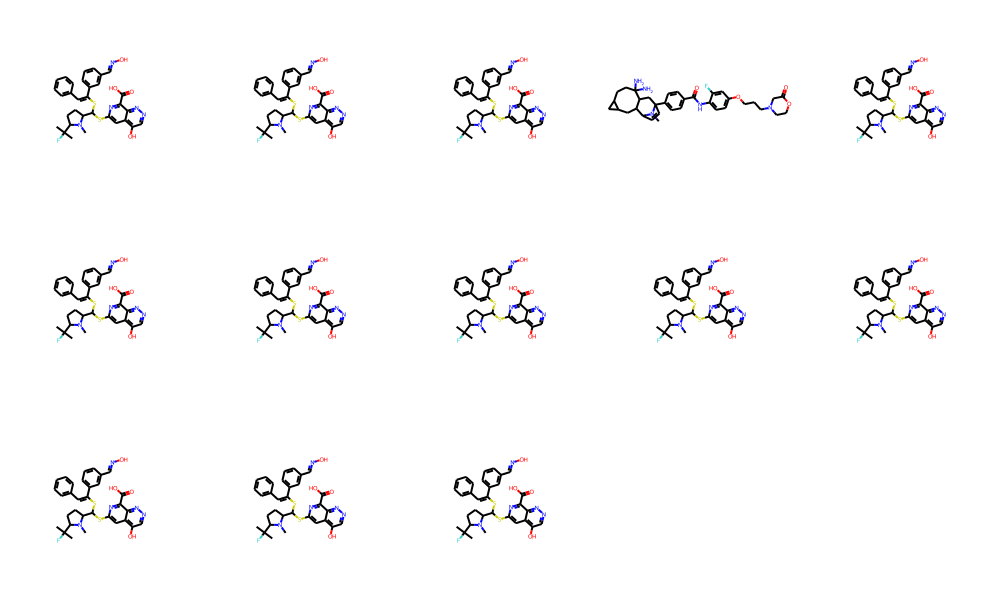

In [ ]:
# generate and plot our generated smiles molecules
latent_seed = latent_space[50:51]
sampling_temp = 0.75
scale = 0.5
quantity = 20
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)
Draw.MolsToGridImage(t_mols, molsPerRow=5)

In [ ]:
print(f'Sampled SMILES:\n {t_smiles}')

Sampled SMILES:
 ['CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C2C=CC1(c1ccc(C(=O)Nc3ccc(OCCCN4CCOC(=O)C4)cc3F)cc1)CC1C2CC2CC2CCC1(N)N', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c

In [ ]:
latent_space.shape[0]-1

99

In [ ]:
# create a for loop to generate molecules based off our sampling dataset's latent space
gen_mols, gen_smiles = [], []
for i in range(10):
  print(i,"=======================================================================================")
  latent_seed = latent_space[i:i+1]
  sampling_temp = rn.uniform(0.75, 1.26)
  scale = 0.75
  quantity = 20
  mols, smiles = generate(latent_seed, sampling_temp, scale, quantity)
  gen_mols.extend(mols)
  gen_smiles.extend(smiles)
  moles, smiles = [], []
print('SMILES generation completed!')

0 =======================================================================================
1/1 [==============================] - 0s 18ms/step


[17:03:37] SMILES Parse Error: extra open parentheses for input: 'COC12Cc4ccc(O)cc2C(=[N+](C(=O)NC2CCC(c3ncccc3COC)C2)Nc2ccc(N3S(=O)(=O)Cc4cccnc4N=C34)CCCCC23)(N1'


1/1 [==============================] - 0s 18ms/step


[17:03:53] SMILES Parse Error: unclosed ring for input: 'COC1c2cccc(c2)C(C)c2ccncc2NC(=O)C2C3CCC4C5C6=C(N)=C(=O)C6(C)C7C(OSC(C)(C)SC(=S)C(CS)CC53)C2'


1/1 [==============================] - 0s 18ms/step


[17:03:59] SMILES Parse Error: unclosed ring for input: 'COC1=Cc2c(N)nnc3nc4c(nc(-c5cc6ccc5C(C)(C(=O)Nc5cc(C(F)(F)F)ccc5C)C(=O)N6)n4C4OCCC4NCC=CC7233)CC3'


1/1 [==============================] - 0s 29ms/step


[17:04:06] SMILES Parse Error: extra close parentheses while parsing: COC1c2ccc(I)cc2C(=O)NC2=CC=C1C=C(C)Oc1c([SH](c3(F)cccc3C3=CN=C(Cc4cccc4)C=CC=C43)c1)C(C2(C)O)C(=O)O)N
[17:04:06] SMILES Parse Error: Failed parsing SMILES 'COC1c2ccc(I)cc2C(=O)NC2=CC=C1C=C(C)Oc1c([SH](c3(F)cccc3C3=CN=C(Cc4cccc4)C=CC=C43)c1)C(C2(C)O)C(=O)O)N' for input: 'COC1c2ccc(I)cc2C(=O)NC2=CC=C1C=C(C)Oc1c([SH](c3(F)cccc3C3=CN=C(Cc4cccc4)C=CC=C43)c1)C(C2(C)O)C(=O)O)N'


1/1 [==============================] - 0s 36ms/step


[17:04:15] SMILES Parse Error: extra open parentheses for input: 'COC1=Cc2c(N)nnc3nc4c(nc(-c5cc6oc(C)(C(=O)NCc5ccc(F)cc5)CCC4OC)C(C(=O)N=C(Br)c4c2=NC=C1)c1c'


1/1 [==============================] - 0s 18ms/step


[17:04:21] SMILES Parse Error: unclosed ring for input: 'COC1=Oc2cccc3c2Cc2ccccc2CCNCC(NC(C)Nc2ccc(F)c(OC)c2)OC(=O)NC3=C(=CC=C2C(=O)NCc2cccc(F)c2)C1=O'


1/1 [==============================] - 0s 26ms/step


[17:04:28] SMILES Parse Error: extra open parentheses for input: 'COC1c2cccc(c2)C(C)c2ccsc2C(C(F)F)N2CCCC(C(F)(F)CNC(=Nc3cccc(N3CC(=O)O)s3)=C2C(=O)c2occc2C2=CO1'


1/1 [==============================] - 0s 28ms/step


[17:04:43] SMILES Parse Error: extra close parentheses while parsing: COC1c2cccc(c2)C(C)OC2CC2)cc1Cc1ccccc1C(N)c1ccc(C(NC(=O)O)C2=CNCc2cc3ccccc3cc2O2ccccc2)c(-n1)c1OC
[17:04:43] SMILES Parse Error: Failed parsing SMILES 'COC1c2cccc(c2)C(C)OC2CC2)cc1Cc1ccccc1C(N)c1ccc(C(NC(=O)O)C2=CNCc2cc3ccccc3cc2O2ccccc2)c(-n1)c1OC' for input: 'COC1c2cccc(c2)C(C)OC2CC2)cc1Cc1ccccc1C(N)c1ccc(C(NC(=O)O)C2=CNCc2cc3ccccc3cc2O2ccccc2)c(-n1)c1OC'


1/1 [==============================] - 0s 36ms/step


[17:04:49] SMILES Parse Error: syntax error while parsing: COC1=Oc2ccc(c3ccc4c(c3)C3C(=O)=C(C)=C(=C2C[SH](C(=O)c4ccc(C(F)(F)F)o+])C2)C2(O)C(F)c2[nH]c(N)nn21
[17:04:49] SMILES Parse Error: Failed parsing SMILES 'COC1=Oc2ccc(c3ccc4c(c3)C3C(=O)=C(C)=C(=C2C[SH](C(=O)c4ccc(C(F)(F)F)o+])C2)C2(O)C(F)c2[nH]c(N)nn21' for input: 'COC1=Oc2ccc(c3ccc4c(c3)C3C(=O)=C(C)=C(=C2C[SH](C(=O)c4ccc(C(F)(F)F)o+])C2)C2(O)C(F)c2[nH]c(N)nn21'


1/1 [==============================] - 0s 19ms/step


[17:05:05] SMILES Parse Error: extra close parentheses while parsing: COC12OCC1CN(c1ccc(C(=O)Nc3ccc(OCCCN4CCOC(=O)C4)cc3F)cc1)CC1CC2C2CCC=C1C(N)NC(=O)c1ccc(C2Cl)=O)c1
[17:05:05] SMILES Parse Error: Failed parsing SMILES 'COC12OCC1CN(c1ccc(C(=O)Nc3ccc(OCCCN4CCOC(=O)C4)cc3F)cc1)CC1CC2C2CCC=C1C(N)NC(=O)c1ccc(C2Cl)=O)c1' for input: 'COC12OCC1CN(c1ccc(C(=O)Nc3ccc(OCCCN4CCOC(=O)C4)cc3F)cc1)CC1CC2C2CCC=C1C(N)NC(=O)c1ccc(C2Cl)=O)c1'


1/1 [==============================] - 0s 21ms/step


[17:05:11] Explicit valence for atom # 11 C, 5, is greater than permitted


1/1 [==============================] - 0s 29ms/step


[17:05:19] SMILES Parse Error: extra open parentheses for input: 'COC1=Cc2cc(ON=O)c3c[nH]c(N4=C(O)=CC4(C(F)(C)C(=O)c([nH]5CC4CC(F)=C3)n2)CC2(CCCNCC2)NCCC(C(F)(F)F)O1'


1/1 [==============================] - 0s 24ms/step


[17:05:28] SMILES Parse Error: extra close parentheses while parsing: COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC1=C7C=CC71C23)C(CC3(CS(=O)(=O)N3)OCC3
[17:05:28] SMILES Parse Error: Failed parsing SMILES 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC1=C7C=CC71C23)C(CC3(CS(=O)(=O)N3)OCC3' for input: 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC1=C7C=CC71C23)C(CC3(CS(=O)(=O)N3)OCC3'


1/1 [==============================] - 0s 18ms/step


[17:05:34] SMILES Parse Error: syntax error while parsing: COC1=Oc2c(cc(N3CCc4cnc[n4-c4ccc(S(=O)(=O)O)cc4)cc3)C=CC=C2C(=O)C(=O)N(Cc3ccc(/C=C/C(=O)O)cc3)C22)O
[17:05:34] SMILES Parse Error: Failed parsing SMILES 'COC1=Oc2c(cc(N3CCc4cnc[n4-c4ccc(S(=O)(=O)O)cc4)cc3)C=CC=C2C(=O)C(=O)N(Cc3ccc(/C=C/C(=O)O)cc3)C22)O' for input: 'COC1=Oc2c(cc(N3CCc4cnc[n4-c4ccc(S(=O)(=O)O)cc4)cc3)C=CC=C2C(=O)C(=O)N(Cc3ccc(/C=C/C(=O)O)cc3)C22)O'


1/1 [==============================] - 0s 33ms/step


[17:05:41] SMILES Parse Error: unclosed ring for input: 'COC12Occccc2[nH]c1-c1nc2n(c1F)CC1CC2CC2CC=C2C(=O)N(Cc2ccc(C(=O)O)cc2)C(Cc2ccccc2)N1C(=O)OCCCO1'


1/1 [==============================] - 0s 25ms/step


[17:05:50] SMILES Parse Error: syntax error while parsing: COC1=Cc2c(N)nc3c(n+][nH]c2c2C(=O)NC(Cc4ccc(F)cc5F)C(=S)NCCCCCCCCS3=CC(F)C(C)(C)(C)=O)N(CCO3CC3)C1
[17:05:50] SMILES Parse Error: Failed parsing SMILES 'COC1=Cc2c(N)nc3c(n+][nH]c2c2C(=O)NC(Cc4ccc(F)cc5F)C(=S)NCCCCCCCCS3=CC(F)C(C)(C)(C)=O)N(CCO3CC3)C1' for input: 'COC1=Cc2c(N)nc3c(n+][nH]c2c2C(=O)NC(Cc4ccc(F)cc5F)C(=S)NCCCCCCCCS3=CC(F)C(C)(C)(C)=O)N(CCO3CC3)C1'


1/1 [==============================] - 0s 20ms/step
1 =======================================================================================
1/1 [==============================] - 0s 18ms/step


[17:05:56] SMILES Parse Error: extra open parentheses for input: 'COC11Cc2ccc(N=O)c3c2CN(C(Cc2ccc(F)cc2F)C(=O)CC(C)N(CCC(F)(C)NC(=O)c2ccc(F)c(F)c2)CC1(F)c1cccc(Cl)c'


1/1 [==============================] - 0s 32ms/step


[17:06:02] SMILES Parse Error: extra open parentheses for input: 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C3CCC(C(F)(F)C(CCSCC(O)CC(O)CC5=O)C(C3C(F)(F)C2)C7'


1/1 [==============================] - 0s 30ms/step


[17:06:10] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15 16 17 18 19 20 21 53


1/1 [==============================] - 0s 21ms/step


[17:06:18] SMILES Parse Error: unclosed ring for input: 'COC1c2cccc(c2)C(C)c2ccccc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N)C(CSC(N5C)C53)O7N77'


1/1 [==============================] - 0s 26ms/step


[17:06:24] Can't kekulize mol.  Unkekulized atoms: 32 33 34


1/1 [==============================] - 0s 27ms/step


[17:06:32] SMILES Parse Error: extra close parentheses while parsing: COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C(=O)NC(C(C)SCCC(C)CCC1)CC(=O)CC24)OC2(C)C3CO)C(=O)O1
[17:06:32] SMILES Parse Error: Failed parsing SMILES 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C(=O)NC(C(C)SCCC(C)CCC1)CC(=O)CC24)OC2(C)C3CO)C(=O)O1' for input: 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C(=O)NC(C(C)SCCC(C)CCC1)CC(=O)CC24)OC2(C)C3CO)C(=O)O1'


1/1 [==============================] - 0s 24ms/step


[17:06:41] SMILES Parse Error: syntax error while parsing: COC1=C2CCC(NN+](C)NC(=O)N3c4cccc(c4)C(Oc3cccc(N)NC(=O)C3Oc3ccc([N+](=O)[O-])cc3)CC2C1(C)[CH(=O)N1
[17:06:41] SMILES Parse Error: Failed parsing SMILES 'COC1=C2CCC(NN+](C)NC(=O)N3c4cccc(c4)C(Oc3cccc(N)NC(=O)C3Oc3ccc([N+](=O)[O-])cc3)CC2C1(C)[CH(=O)N1' for input: 'COC1=C2CCC(NN+](C)NC(=O)N3c4cccc(c4)C(Oc3cccc(N)NC(=O)C3Oc3ccc([N+](=O)[O-])cc3)CC2C1(C)[CH(=O)N1'


1/1 [==============================] - 0s 21ms/step


[17:06:48] SMILES Parse Error: extra open parentheses for input: 'COC1c2cccc(c2)C(C)c2ccccc2NC(=C2CSC(C)(C)N(C)C(=O)N(COCC2OCC2CCC(F)C2)C(=O)CC2n3cccc(C4CCCN4)c3c21'


1/1 [==============================] - 0s 28ms/step


[17:06:55] SMILES Parse Error: extra open parentheses for input: 'COC12OCC1CN(c1ccc(C(=O)Cc3ccc(OCCCN4CCOC(=O)C4)cc3F)cc1C(c1ccc(O)cc1C(N)=O)C2(C)c1cccc(Cl)c1'


1/1 [==============================] - 0s 19ms/step


[17:07:04] SMILES Parse Error: unclosed ring for input: 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2CCC2C2CCCNC(C(=O)NC(=O)C34CCn5CC(C5=C)N(CCC(F)CCCC)C3)C2C(O)C1'


1/1 [==============================] - 0s 17ms/step


[17:07:10] SMILES Parse Error: extra open parentheses for input: 'COC12OCC1CN(c1ccc(C(=O)Nc3ccc(Cl)cc3-c3ccc(CC(=O)O)cc3)ccc1CCC1CC2(C(F)(F)F)C(=O)C(=O)c2c(sc2=O)N1'


1/1 [==============================] - 0s 29ms/step


[17:07:18] SMILES Parse Error: unclosed ring for input: 'COC1=Cc2c(N)nnc3nc4c(nc(-c5cc6ccc5C(C)(C(=O)Nc5cc(C(F)(F)F)ccc5C)C(=O)N6)n4c4cccc4C3)C(=O)N1C'


1/1 [==============================] - 0s 19ms/step


[17:07:27] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9


1/1 [==============================] - 0s 26ms/step


[17:07:33] SMILES Parse Error: syntax error while parsing: COC1=Cc2c(N)nnc3nc4c(nc(-c5cc6ccc5C(C)(C(=O)Nc5cc(C(F)(F)F)ccc5C)C(=O)N6)n4C4OCCC34)cc2CC1CC(
[17:07:33] SMILES Parse Error: Failed parsing SMILES 'COC1=Cc2c(N)nnc3nc4c(nc(-c5cc6ccc5C(C)(C(=O)Nc5cc(C(F)(F)F)ccc5C)C(=O)N6)n4C4OCCC34)cc2CC1CC(' for input: 'COC1=Cc2c(N)nnc3nc4c(nc(-c5cc6ccc5C(C)(C(=O)Nc5cc(C(F)(F)F)ccc5C)C(=O)N6)n4C4OCCC34)cc2CC1CC('


1/1 [==============================] - 0s 35ms/step


[17:07:40] SMILES Parse Error: extra open parentheses for input: 'COC1=Oc2cccc3c2c(C)c2c(C)cc(n(CCO)c(N)c2CCCCCCCCCCCCSCC(Sc2ccc(Oc4ccc(C(=O)O)cc4)CC23)c2ccccc2OC1'


1/1 [==============================] - 0s 27ms/step


[17:07:49] SMILES Parse Error: extra close parentheses while parsing: COC1=Cc2cc(Oc3ccc(CNC(=O)O)cc3)cc-2=c-3cccc2C2Cc3cccc(c(C)(C)(C)c2)NC3=O)C(C(=O)O)C2(C)C=CCC2=ON1
[17:07:49] SMILES Parse Error: Failed parsing SMILES 'COC1=Cc2cc(Oc3ccc(CNC(=O)O)cc3)cc-2=c-3cccc2C2Cc3cccc(c(C)(C)(C)c2)NC3=O)C(C(=O)O)C2(C)C=CCC2=ON1' for input: 'COC1=Cc2cc(Oc3ccc(CNC(=O)O)cc3)cc-2=c-3cccc2C2Cc3cccc(c(C)(C)(C)c2)NC3=O)C(C(=O)O)C2(C)C=CCC2=ON1'


1/1 [==============================] - 0s 25ms/step


[17:07:57] non-ring atom 31 marked aromatic


1/1 [==============================] - 0s 27ms/step


[17:08:04] SMILES Parse Error: extra close parentheses while parsing: COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(=O)(=O)N=CC6)C5(=O)N=CCC3)C72C35
[17:08:04] SMILES Parse Error: Failed parsing SMILES 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(=O)(=O)N=CC6)C5(=O)N=CCC3)C72C35' for input: 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(=O)(=O)N=CC6)C5(=O)N=CCC3)C72C35'


1/1 [==============================] - 0s 30ms/step


[17:08:13] SMILES Parse Error: extra close parentheses while parsing: COC12OCC1CO21cccc2c1CCCC(C)(N)=O)CCNCCC(CCN(C)C(=O)NC(=NCc3ccc(F)cc13)C3)c2cccc(C#N)c1C(F)F)c1
[17:08:13] SMILES Parse Error: Failed parsing SMILES 'COC12OCC1CO21cccc2c1CCCC(C)(N)=O)CCNCCC(CCN(C)C(=O)NC(=NCc3ccc(F)cc13)C3)c2cccc(C#N)c1C(F)F)c1' for input: 'COC12OCC1CO21cccc2c1CCCC(C)(N)=O)CCNCCC(CCN(C)C(=O)NC(=NCc3ccc(F)cc13)C3)c2cccc(C#N)c1C(F)F)c1'


1/1 [==============================] - 0s 22ms/step


[17:08:20] SMILES Parse Error: syntax error while parsing: COC1c2cccc(c2)C(C)c2sccc2NNC(=O)C2CC3n4cncc(3)c(Cl)C2C(=O)C(=S)N(Cc2cc(=O)c(OC)c(=O)C=C2C)C(=O)O1
[17:08:20] SMILES Parse Error: Failed parsing SMILES 'COC1c2cccc(c2)C(C)c2sccc2NNC(=O)C2CC3n4cncc(3)c(Cl)C2C(=O)C(=S)N(Cc2cc(=O)c(OC)c(=O)C=C2C)C(=O)O1' for input: 'COC1c2cccc(c2)C(C)c2sccc2NNC(=O)C2CC3n4cncc(3)c(Cl)C2C(=O)C(=S)N(Cc2cc(=O)c(OC)c(=O)C=C2C)C(=O)O1'


1/1 [==============================] - 0s 29ms/step
2 =======================================================================================
1/1 [==============================] - 0s 31ms/step


[17:08:26] SMILES Parse Error: extra open parentheses for input: 'COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OC3(O)CC(=O)N(C)CC3C2CCC(C(=O)N3)OC1=O'


1/1 [==============================] - 0s 29ms/step


[17:08:32] SMILES Parse Error: extra close parentheses while parsing: NC1CCC2=CN(N)C3=Cc4ccccc4C(=CC=C2)[C@H](C=O)S(C)(=O)=O)n1c1=N
[17:08:32] SMILES Parse Error: Failed parsing SMILES 'NC1CCC2=CN(N)C3=Cc4ccccc4C(=CC=C2)[C@H](C=O)S(C)(=O)=O)n1c1=N' for input: 'NC1CCC2=CN(N)C3=Cc4ccccc4C(=CC=C2)[C@H](C=O)S(C)(=O)=O)n1c1=N'


1/1 [==============================] - 0s 29ms/step


[17:08:38] SMILES Parse Error: unclosed ring for input: 'NC1CCC2=CN(N)C3=Cc4c(ccnc31)C(=O)NCc1c(Cl)c[n+](C=O)c3cc1Cl'


1/1 [==============================] - 0s 17ms/step


[17:08:42] SMILES Parse Error: extra close parentheses while parsing: NCC12CC(Br)=NC(NCc3ccc4ccccc4c3Oc3cccc(C4CCC(F)C4)c3)CC1=O)C2
[17:08:42] SMILES Parse Error: Failed parsing SMILES 'NCC12CC(Br)=NC(NCc3ccc4ccccc4c3Oc3cccc(C4CCC(F)C4)c3)CC1=O)C2' for input: 'NCC12CC(Br)=NC(NCc3ccc4ccccc4c3Oc3cccc(C4CCC(F)C4)c3)CC1=O)C2'


1/1 [==============================] - 0s 25ms/step


[17:08:46] SMILES Parse Error: unclosed ring for input: 'NC1CC(O)C23CCCCC2C1c1ccccc1NC(=O)c1c(cc(C#CC(=O)O)ccc1=O)c1'


1/1 [==============================] - 0s 28ms/step


[17:08:51] SMILES Parse Error: unclosed ring for input: 'NC1CCC2=CN(N)C3=CC=C2C1=CN=C(C=C(=C)Cn4cccc(F)c4Cl)C1C(F)(F)c1ccccc2'


1/1 [==============================] - 0s 35ms/step


[17:08:57] SMILES Parse Error: extra close parentheses while parsing: NC1CCC2=CN(N)C3=CC(c4cccc(F)c4F)=CCC3c3ccccc3)C(=O)NC21C=NNC
[17:08:57] SMILES Parse Error: Failed parsing SMILES 'NC1CCC2=CN(N)C3=CC(c4cccc(F)c4F)=CCC3c3ccccc3)C(=O)NC21C=NNC' for input: 'NC1CCC2=CN(N)C3=CC(c4cccc(F)c4F)=CCC3c3ccccc3)C(=O)NC21C=NNC'


1/1 [==============================] - 0s 27ms/step


[17:09:03] SMILES Parse Error: unclosed ring for input: 'NC1CCC2N3CCN(C(C(O)c4ccc5cccc5Cc4nccc5cccc(C(=O)O)c4n3)C2)ON1'


1/1 [==============================] - 0s 19ms/step


[17:09:07] SMILES Parse Error: extra close parentheses while parsing: NC1CCC2=CN(N)C3CCNc4cccc(Cl)(C)CC4CCC(F)(F)C3=O)N(CC2OC)C(O)C1=C
[17:09:07] SMILES Parse Error: Failed parsing SMILES 'NC1CCC2=CN(N)C3CCNc4cccc(Cl)(C)CC4CCC(F)(F)C3=O)N(CC2OC)C(O)C1=C' for input: 'NC1CCC2=CN(N)C3CCNc4cccc(Cl)(C)CC4CCC(F)(F)C3=O)N(CC2OC)C(O)C1=C'


1/1 [==============================] - 0s 24ms/step


[17:09:12] SMILES Parse Error: extra close parentheses while parsing: NC1CC(O)C23CCC1C2CCc1c([N+](=O)[O-])c[n+]([O-])c2C=CC=C3)c(=O)c1=O
[17:09:12] SMILES Parse Error: Failed parsing SMILES 'NC1CC(O)C23CCC1C2CCc1c([N+](=O)[O-])c[n+]([O-])c2C=CC=C3)c(=O)c1=O' for input: 'NC1CC(O)C23CCC1C2CCc1c([N+](=O)[O-])c[n+]([O-])c2C=CC=C3)c(=O)c1=O'


1/1 [==============================] - 0s 34ms/step


[17:09:18] SMILES Parse Error: ring closure 3 duplicates bond between atom 23 and atom 24 for input: 'CN=C1CCC2(C)N(CCC(c3cccc(NC(=O)O)c3)C(=O)N3c3cc(F)c(F)c3)CC21'


1/1 [==============================] - 0s 28ms/step


[17:09:25] SMILES Parse Error: unclosed ring for input: 'NC1CC(O2CN(S)C3CC4Cc2cccc24C=CC=C34c3cc(C(=O)n4cccc4C(=O)O)cc31)C2=C'


1/1 [==============================] - 0s 25ms/step


[17:09:30] SMILES Parse Error: extra close parentheses while parsing: NC1CCC2(CCN(C)C)Cc3ccc(C(=O)Nc4ccc(=O)c(=O)c4)cc3)C(=O)C1=CC1
[17:09:30] SMILES Parse Error: Failed parsing SMILES 'NC1CCC2(CCN(C)C)Cc3ccc(C(=O)Nc4ccc(=O)c(=O)c4)cc3)C(=O)C1=CC1' for input: 'NC1CCC2(CCN(C)C)Cc3ccc(C(=O)Nc4ccc(=O)c(=O)c4)cc3)C(=O)C1=CC1'


1/1 [==============================] - 0s 19ms/step


[17:09:34] SMILES Parse Error: unclosed ring for input: 'NC1CCC2=CN(N)C3=Cc4cccc(c4=C3Cc1cccc(Cl)cc1)C(F)C(F)(F)C2'


1/1 [==============================] - 0s 31ms/step


[17:09:44] SMILES Parse Error: extra close parentheses while parsing: NC1CCC2=CN(N)C3=Cc4c(ccnc4-3)C(=O)NC(=O)C2(CNC(C)C)C(=O)O)c(=O)=O1
[17:09:44] SMILES Parse Error: Failed parsing SMILES 'NC1CCC2=CN(N)C3=Cc4c(ccnc4-3)C(=O)NC(=O)C2(CNC(C)C)C(=O)O)c(=O)=O1' for input: 'NC1CCC2=CN(N)C3=Cc4c(ccnc4-3)C(=O)NC(=O)C2(CNC(C)C)C(=O)O)c(=O)=O1'


1/1 [==============================] - 0s 30ms/step


[17:09:50] SMILES Parse Error: extra open parentheses for input: 'NCC1CC2CC(NC(C(Cl)Nc3ccc(Oc4ccccc4Oc4ccccc4O4)ccc3NC3=NC=CC31)C'


1/1 [==============================] - 0s 24ms/step


[17:09:55] SMILES Parse Error: extra open parentheses for input: 'NC1CCN2C3CCNC4C(Cc2c(O)cc(OC)C2SC(c2cc(Cl)[nH]c(=O)C(F)C3)c1'


1/1 [==============================] - 0s 17ms/step


[17:09:59] SMILES Parse Error: extra open parentheses for input: 'NC1CCc2c(C)cccc2C(=O)NC2=C(C=Cc3nc(Cl)[nH]c(=O)c3-c3cc3cccc3c3'


1/1 [==============================] - 0s 26ms/step


[17:10:04] SMILES Parse Error: extra open parentheses for input: 'NC1CC(O)C23CCC1C2C(Cc1c2cc(Oc2ccc(c(=O)Nc4ccccc4O)n[n+]1C2=O)O3C1'


1/1 [==============================] - 0s 27ms/step
3 =======================================================================================
1/1 [==============================] - 0s 30ms/step


[17:10:09] SMILES Parse Error: extra open parentheses for input: 'NC1CC(F)C2CCCC1CC(CCN(CC(N)=O)C(F)(F)N1C(=O)CCc1c(N)ccc(N)c1C2'


1/1 [==============================] - 0s 20ms/step


[17:10:16] SMILES Parse Error: extra open parentheses for input: 'CC1CC2(OC(C(=O)NCCN(C)C(=O)C(Oc3ccc(F)cc3C3CCCCC3)N3C(=CCc4cc(F)ccc43)CC1'


1/1 [==============================] - 0s 20ms/step


[17:10:21] SMILES Parse Error: extra close parentheses while parsing: CC1CC2N(C)CCCNCC=C3C=CC=C3CC=CSC(C(=O)NC(Cl)c3cccc(N4CCCC5=O)N4)=C3O)O12
[17:10:21] SMILES Parse Error: Failed parsing SMILES 'CC1CC2N(C)CCCNCC=C3C=CC=C3CC=CSC(C(=O)NC(Cl)c3cccc(N4CCCC5=O)N4)=C3O)O12' for input: 'CC1CC2N(C)CCCNCC=C3C=CC=C3CC=CSC(C(=O)NC(Cl)c3cccc(N4CCCC5=O)N4)=C3O)O12'


1/1 [==============================] - 0s 33ms/step


[17:10:26] SMILES Parse Error: extra close parentheses while parsing: CC1CC2COC(C(=O)NC(CO)CC(=O)N1)N=C(Cl)C=CC=C1C(=O)Nc3ccccc13)CN2CCC[n+]1
[17:10:26] SMILES Parse Error: Failed parsing SMILES 'CC1CC2COC(C(=O)NC(CO)CC(=O)N1)N=C(Cl)C=CC=C1C(=O)Nc3ccccc13)CN2CCC[n+]1' for input: 'CC1CC2COC(C(=O)NC(CO)CC(=O)N1)N=C(Cl)C=CC=C1C(=O)Nc3ccccc13)CN2CCC[n+]1'


1/1 [==============================] - 0s 37ms/step


[17:10:33] SMILES Parse Error: unclosed ring for input: 'CC1CC23CCCCC2CCC1C3CCCCCC1C(C)(O)N(CNC(=O)C(N)Cc1cccc(N)c1)c1ccccc1I'


1/1 [==============================] - 0s 22ms/step


[17:10:40] SMILES Parse Error: extra open parentheses for input: 'CC1CC2N(C)CCCNCC=C(Cl)C3CC=CS(=O)(=[SH]CC(O)C2CCCN(C(=O)CCc2ccccc2F)N1'


1/1 [==============================] - 0s 20ms/step


[17:10:45] SMILES Parse Error: unclosed ring for input: 'CC1CC2=CC=C(C=CC3CNC4=C(C=C(C(=O)O)C=CC=NC3)C(=O)N(COC(CO)CCO)CC2)OC1'


1/1 [==============================] - 0s 29ms/step


[17:10:50] SMILES Parse Error: unclosed ring for input: 'CC1CC2N(C)CCCCCC=CC3=CN(NC(=O)CC(O)C23)C1=CC=C1C(=O)NO[N+]1=NC(=O)NOCN1N'


1/1 [==============================] - 0s 26ms/step


[17:11:09] SMILES Parse Error: unclosed ring for input: 'CC1CC2N(C)CCCNCC=C(Cl)C3CC=CS(=O)(=[SH]CC(Oc4cc(F)ccc4F)N(CC4CCCCCCO)CC3)C12'


1/1 [==============================] - 0s 29ms/step


[17:11:20] SMILES Parse Error: extra open parentheses for input: 'CC1CC2COC(C(=O)NC(C3CCC(C4CCCN(C)C(=O)Cc4ccc5c(C)CC(=O)N6)nc43)CC21CCl'


1/1 [==============================] - 0s 21ms/step


[17:11:32] SMILES Parse Error: unclosed ring for input: 'CC1CC2N(C)CCCNCCC(=CN=C3(C)C(CO)(CO)CC(O)C43)c3cccc(c4C)[CH](=O)C(F)CC21'


1/1 [==============================] - 0s 20ms/step


[17:11:37] SMILES Parse Error: unclosed ring for input: 'CC1CC2N(C)CCCNCCN(C(=O)CC3CCC(CS(C)(C)=C(N)c3ccc(Cl)c(O)c3)c(F)c2NC)C(=O)O1'


1/1 [==============================] - 0s 32ms/step


[17:11:43] SMILES Parse Error: extra open parentheses for input: 'CC1CC2(CCCC1CCCN(C)C)CNC(=O)NCCOCCC(C)N(CC(O)C(=O)NC(O)CC(=O)NC1CCC2CO'


1/1 [==============================] - 0s 40ms/step


[17:11:51] SMILES Parse Error: extra close parentheses while parsing: CC1CC2N(C)CCCNCC=C(Cl)C3CC=CS(=O)(=O)N1C3(C)COC(C(=O)NCCCCF)C3)CCN2CON1COC
[17:11:51] SMILES Parse Error: Failed parsing SMILES 'CC1CC2N(C)CCCNCC=C(Cl)C3CC=CS(=O)(=O)N1C3(C)COC(C(=O)NCCCCF)C3)CCN2CON1COC' for input: 'CC1CC2N(C)CCCNCC=C(Cl)C3CC=CS(=O)(=O)N1C3(C)COC(C(=O)NCCCCF)C3)CCN2CON1COC'


1/1 [==============================] - 0s 23ms/step


[17:11:57] SMILES Parse Error: unclosed ring for input: 'CC1CC2COC(C(=O)NC(COC(Cl)C(C)C(NS(C)(C)=O)=OC3)C(=C2)C1=O)c1ccc(Cl)cc1'


1/1 [==============================] - 0s 38ms/step
4 =======================================================================================
1/1 [==============================] - 0s 31ms/step


[17:12:14] SMILES Parse Error: extra close parentheses while parsing: O=C1OCOC2(F)C(Cl)=Cc3cc(F)cc(C4COc3ccc(F)cc3)NC3Oc4cccc(Cl)c4O3)CC12=O
[17:12:14] SMILES Parse Error: Failed parsing SMILES 'O=C1OCOC2(F)C(Cl)=Cc3cc(F)cc(C4COc3ccc(F)cc3)NC3Oc4cccc(Cl)c4O3)CC12=O' for input: 'O=C1OCOC2(F)C(Cl)=Cc3cc(F)cc(C4COc3ccc(F)cc3)NC3Oc4cccc(Cl)c4O3)CC12=O'


1/1 [==============================] - 0s 22ms/step


[17:12:20] SMILES Parse Error: unclosed ring for input: 'O=C1CCC2(CCC34C=NN(C3)C3C4Cc6nccc5c3CCCCC6(C)NCC(C(=O)OC)=O)CC34C72O'


1/1 [==============================] - 0s 19ms/step


[17:12:24] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC2(CCC34C=NN(C3)c3cc(Cc5nc(OC(C(=O)NC=O)c5ccc(Cl)cc5N4)n3)CC2=CO1'


1/1 [==============================] - 0s 28ms/step


[17:12:30] SMILES Parse Error: extra close parentheses while parsing: O=C12CCC=C(CF)(C3CCCc4ccc(F)cc4NC3=OC3=C[N+](NC1=C(F)C(C)O)CC3F)[C@H]2)C1
[17:12:30] SMILES Parse Error: Failed parsing SMILES 'O=C12CCC=C(CF)(C3CCCc4ccc(F)cc4NC3=OC3=C[N+](NC1=C(F)C(C)O)CC3F)[C@H]2)C1' for input: 'O=C12CCC=C(CF)(C3CCCc4ccc(F)cc4NC3=OC3=C[N+](NC1=C(F)C(C)O)CC3F)[C@H]2)C1'


1/1 [==============================] - 0s 28ms/step


[17:12:37] SMILES Parse Error: syntax error while parsing: O=C1OCOC2(F)C(Cl)=C(c3cc(C=[[H])nc3=Nc3ccc(C[O-])nc3)c3ccccc3NO)N1C2C2
[17:12:37] SMILES Parse Error: Failed parsing SMILES 'O=C1OCOC2(F)C(Cl)=C(c3cc(C=[[H])nc3=Nc3ccc(C[O-])nc3)c3ccccc3NO)N1C2C2' for input: 'O=C1OCOC2(F)C(Cl)=C(c3cc(C=[[H])nc3=Nc3ccc(C[O-])nc3)c3ccccc3NO)N1C2C2'


1/1 [==============================] - 0s 19ms/step


[17:12:43] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC2(CCC34C=N(Cc3cc(C(F)(F)(F)ccc5)C(=O)SC(c3cccnc3)NC4)OCCO2N1N'


1/1 [==============================] - 0s 18ms/step


[17:12:47] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC2(CCC34C=NN(c3cc(C(=O)OC(=O)Nc5cccc(F)c3)CC(Oc3cccco3)S4)CC2S1'


1/1 [==============================] - 0s 30ms/step


[17:12:57] SMILES Parse Error: extra open parentheses for input: 'O=C1OCOC2(F)C(Cl)=Cc3ccc(F)cc3CCN1C(=O)OC(N(CCO)CC=CC=C1C=C2COOC2=C1'


1/1 [==============================] - 0s 29ms/step


[17:13:03] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC2(CN3CCCCC4Ccc4c(c4)C3=C1C=C(c3ncccc3Cl)SC1=C[N+](C=[O-])C=C2N1'


1/1 [==============================] - 0s 27ms/step


[17:13:09] SMILES Parse Error: unclosed ring for input: 'O=C1CCC2(CCN(C(=O)Oc3ccc(Cl)[nH]n(O)c3)N3c3cc(F)ccc3Cl)CC=C2C(=C)NCC3'


1/1 [==============================] - 0s 25ms/step


[17:13:15] SMILES Parse Error: syntax error while parsing: O=C1OCOC2(F)C(C)C(CCc3cccc(F)c3)C(=O)N2C3(CF)C(Cl)=CN=[N@H(=O)[NH]3=#N
[17:13:15] SMILES Parse Error: Failed parsing SMILES 'O=C1OCOC2(F)C(C)C(CCc3cccc(F)c3)C(=O)N2C3(CF)C(Cl)=CN=[N@H(=O)[NH]3=#N' for input: 'O=C1OCOC2(F)C(C)C(CCc3cccc(F)c3)C(=O)N2C3(CF)C(Cl)=CN=[N@H(=O)[NH]3=#N'


1/1 [==============================] - 0s 31ms/step


[17:13:22] SMILES Parse Error: unclosed ring for input: 'CN1CCC2=C3C=NC(=CC(c5ccc(C)cc4F)C(=O)NCC2OCC2OC(=O)C(S)(NC=O)(N=O)=33)C1=C'


1/1 [==============================] - 0s 29ms/step


[17:13:28] Can't kekulize mol.  Unkekulized atoms: 9 11 28 29


1/1 [==============================] - 0s 24ms/step


[17:13:33] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC2(CCC34C=NN(c3ccc(C(=COS(=O)(=O)O)cc3)NC2=Oc3cc([nH][nH]n23)C1N'


1/1 [==============================] - 0s 25ms/step


[17:13:37] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC2(CCC34C=NN(c3cc(F)cc3Cl)C3C(=OO)Cc4c(Cl)[nH]c(=O)cn1CC1(CO2'


1/1 [==============================] - 0s 32ms/step


[17:13:43] SMILES Parse Error: extra close parentheses while parsing: O=C1C2C[N+](C[N+](=O)[O-])C3=C(NC1c4ccccc4O)C(=O)NC(=O)NC(Cl)=CC3)c1=O
[17:13:43] SMILES Parse Error: Failed parsing SMILES 'O=C1C2C[N+](C[N+](=O)[O-])C3=C(NC1c4ccccc4O)C(=O)NC(=O)NC(Cl)=CC3)c1=O' for input: 'O=C1C2C[N+](C[N+](=O)[O-])C3=C(NC1c4ccccc4O)C(=O)NC(=O)NC(Cl)=CC3)c1=O'


1/1 [==============================] - 0s 27ms/step


[17:13:50] SMILES Parse Error: unclosed ring for input: 'O=C1C2CCC3(C=C2SC(Nc4ccccc4O)C(=O)NCCCCCCCC3C2CO3Oc4cccn4C4C2OCF3)CN1'


1/1 [==============================] - ETA: 0s

[17:13:56] Explicit valence for atom # 34 O, 3, is greater than permitted


1/1 [==============================] - 0s 20ms/step
5 =======================================================================================
1/1 [==============================] - 0s 21ms/step


[17:14:01] SMILES Parse Error: syntax error while parsing: O=C1C2CCC3(C=C(Br)cccc33c3cccc(F)cc3F)C(=O)N=[N-3=C(O)C(CSC(N)(=O)O1)oc1
[17:14:01] SMILES Parse Error: Failed parsing SMILES 'O=C1C2CCC3(C=C(Br)cccc33c3cccc(F)cc3F)C(=O)N=[N-3=C(O)C(CSC(N)(=O)O1)oc1' for input: 'O=C1C2CCC3(C=C(Br)cccc33c3cccc(F)cc3F)C(=O)N=[N-3=C(O)C(CSC(N)(=O)O1)oc1'


1/1 [==============================] - 0s 30ms/step


[17:14:08] SMILES Parse Error: unclosed ring for input: 'CC1CC2=CC=C(C=CC3C=CC(NS(C)(ccccc(C(=O)O)[n+](C=C)[O-])cc3)C(=O)NS2=O)N3CCCC(c2c(F)cccc21)C1'


1/1 [==============================] - 0s 28ms/step


[17:14:17] Can't kekulize mol.  Unkekulized atoms: 18 20 21 27 29


1/1 [==============================] - 0s 18ms/step


[17:14:23] SMILES Parse Error: syntax error while parsing: CC1C2[S+](COCC=C3C=CS(=O)(=O)c4cccc(4)(C)CC3S3CC3C3=C[N+](=C)N3CC3CCCCC(C)N3)CC2=CCN1CN
[17:14:23] SMILES Parse Error: Failed parsing SMILES 'CC1C2[S+](COCC=C3C=CS(=O)(=O)c4cccc(4)(C)CC3S3CC3C3=C[N+](=C)N3CC3CCCCC(C)N3)CC2=CCN1CN' for input: 'CC1C2[S+](COCC=C3C=CS(=O)(=O)c4cccc(4)(C)CC3S3CC3C3=C[N+](=C)N3CC3CCCCC(C)N3)CC2=CCN1CN'


1/1 [==============================] - 0s 33ms/step


[17:14:31] SMILES Parse Error: unclosed ring for input: 'CC1CC2=CC=C(C=C3C(O)CC(=O)Nc4cccc(C(SC)Cc4nc(Cl)cc(F)c3C(C)CC(C(C)SC)(C4OCCCF)CC3)O4)OC21'


1/1 [==============================] - 0s 26ms/step


[17:14:41] SMILES Parse Error: extra close parentheses while parsing: CC1CC2=CC=C(C=CC3CCC4N5C(=O)Cc4ccc5c5CCC5CC=CC=C(C(C)SC)n4)C(CCCC(O)(CO)CO3)Nc3ccc(O)c3O)C2=CC1
[17:14:41] SMILES Parse Error: Failed parsing SMILES 'CC1CC2=CC=C(C=CC3CCC4N5C(=O)Cc4ccc5c5CCC5CC=CC=C(C(C)SC)n4)C(CCCC(O)(CO)CO3)Nc3ccc(O)c3O)C2=CC1' for input: 'CC1CC2=CC=C(C=CC3CCC4N5C(=O)Cc4ccc5c5CCC5CC=CC=C(C(C)SC)n4)C(CCCC(O)(CO)CO3)Nc3ccc(O)c3O)C2=CC1'


1/1 [==============================] - 0s 19ms/step


[17:14:47] SMILES Parse Error: extra close parentheses while parsing: CC1CC2=CC=C(C=C3CC(OC)CC4=Cc5ccccc45)C3OCCCCCC(F)(F)F)C=C2CC(=O)N2CC3CCC(C4)NC(C3)C2)OC1
[17:14:47] SMILES Parse Error: Failed parsing SMILES 'CC1CC2=CC=C(C=C3CC(OC)CC4=Cc5ccccc45)C3OCCCCCC(F)(F)F)C=C2CC(=O)N2CC3CCC(C4)NC(C3)C2)OC1' for input: 'CC1CC2=CC=C(C=C3CC(OC)CC4=Cc5ccccc45)C3OCCCCCC(F)(F)F)C=C2CC(=O)N2CC3CCC(C4)NC(C3)C2)OC1'


1/1 [==============================] - 0s 34ms/step


[17:14:54] SMILES Parse Error: extra open parentheses for input: 'CC1C2=CC=CC=CC(=O)C34C=CC(c5ccccc5)NCC4CCCCC=CC(=C)SC(=S)NC4(C)N(C(=O)C([SH](C)(C)=C3)c3c1c/I'


1/1 [==============================] - 0s 28ms/step


[17:15:03] SMILES Parse Error: extra open parentheses for input: 'CC1CC2OCCC1BCC(=O)NC(C(F)(C)c1cccc(NC(=O)c3ccc3cccc3c1F)N(C(=O)OC1CCCCCC2)CC1C3CC1CC(O)(CO)O'


1/1 [==============================] - 0s 22ms/step


[17:15:11] SMILES Parse Error: extra open parentheses for input: 'CC1CC2CCCC12SCC(C2CCC(N2CC(cc2ccccc2)C(O)C2CCCCC2NS(=O)(=O)Cc2ccccc2)c(NS(=O)(=O)C2CC2C(=O)O)C1'


1/1 [==============================] - 0s 22ms/step


[17:15:17] SMILES Parse Error: unclosed ring for input: 'CC1CC2=CC=C(C=NO)C3(C=C)SC(cccc(OC)[C](N)c4ccc(F)cc3NC2)NC(=O)C2CC3CC(N(C)C(=O)C(CO)C3)C21'


1/1 [==============================] - 0s 29ms/step


[17:15:25] SMILES Parse Error: extra open parentheses for input: 'CC1CC2=CC=C(C=CC3CNC4=C(C(OC(C)S)C5(CCC(c5ccc(F)cc5)C)C(C)C3CCN(C(C)SC)C(=O)OCO3)CC2CO1'


1/1 [==============================] - 0s 20ms/step


[17:15:40] SMILES Parse Error: extra close parentheses while parsing: CC1CC2=CC=C(C=CC3CCCNC(C)(C)Cc(nc-ccc3Cc3cccnc3)NC2=O)C(=O)N(Cc2ccc(/C=O)c(F)c2)C(=O)O1)-c1cnsn1
[17:15:40] SMILES Parse Error: Failed parsing SMILES 'CC1CC2=CC=C(C=CC3CCCNC(C)(C)Cc(nc-ccc3Cc3cccnc3)NC2=O)C(=O)N(Cc2ccc(/C=O)c(F)c2)C(=O)O1)-c1cnsn1' for input: 'CC1CC2=CC=C(C=CC3CCCNC(C)(C)Cc(nc-ccc3Cc3cccnc3)NC2=O)C(=O)N(Cc2ccc(/C=O)c(F)c2)C(=O)O1)-c1cnsn1'


1/1 [==============================] - 0s 35ms/step


[17:15:48] SMILES Parse Error: extra close parentheses while parsing: CC1OC(C(=O)N2CC(C)C3CCC4C(Cc5ccc(F)cc5C)C4CC=CCC=C(CC)CCC3)C(=O)C(O)C2O)C(=O)NC(CNCCCO)NC=ON1
[17:15:48] SMILES Parse Error: Failed parsing SMILES 'CC1OC(C(=O)N2CC(C)C3CCC4C(Cc5ccc(F)cc5C)C4CC=CCC=C(CC)CCC3)C(=O)C(O)C2O)C(=O)NC(CNCCCO)NC=ON1' for input: 'CC1OC(C(=O)N2CC(C)C3CCC4C(Cc5ccc(F)cc5C)C4CC=CCC=C(CC)CCC3)C(=O)C(O)C2O)C(=O)NC(CNCCCO)NC=ON1'


1/1 [==============================] - 0s 19ms/step


[17:15:57] SMILES Parse Error: extra close parentheses while parsing: CC1CC2=CC=C(C)C3CCC4C4=O)N(C3c3cccc(/C=CS(=O)(=C)[n+]3CC3)C4CCCCC(C(C)N)(=O)=C3)C2=NO1
[17:15:57] SMILES Parse Error: Failed parsing SMILES 'CC1CC2=CC=C(C)C3CCC4C4=O)N(C3c3cccc(/C=CS(=O)(=C)[n+]3CC3)C4CCCCC(C(C)N)(=O)=C3)C2=NO1' for input: 'CC1CC2=CC=C(C)C3CCC4C4=O)N(C3c3cccc(/C=CS(=O)(=C)[n+]3CC3)C4CCCCC(C(C)N)(=O)=C3)C2=NO1'


1/1 [==============================] - 0s 18ms/step


[17:16:03] SMILES Parse Error: unclosed ring for input: 'CC1CC2=CC=C(C=CS(=O)(=O)C3(c4ccccc4)c4c3CCC(C(=O)=C)C73C(F)C(=O)C3(Cl)CCC(F)F)(F)CCO21'


1/1 [==============================] - 0s 32ms/step


[17:16:10] SMILES Parse Error: unclosed ring for input: 'CC1Cn2cc(C(=O)N3CCC(c4cccc(C(=O)O)c4)CC3=C3C=CC=CC(=C)N(CC3CCN(C)C)C=C3)Oc2c2ccccc2NC(=O)N1'


1/1 [==============================] - 0s 19ms/step


[17:16:25] SMILES Parse Error: unclosed ring for input: 'CC1CC2OCC(CCC3CCCCNS(=O)(=O)Cc2-c3ccc3ccccc2C#N)C1C(=O)N(C)Nc1nc(=O)o[nH]1'


1/1 [==============================] - 0s 27ms/step
6 =======================================================================================
1/1 [==============================] - 0s 30ms/step


[17:16:31] SMILES Parse Error: extra open parentheses for input: 'CC1CC2=CC=C1C=C(F)C3CC=CC(Cc4ccccc43)NC(CCCCNCC(O)CC(=O)NC(O)C1=[SH]3C(N)=CC(=C3)NC(=CC21)Cl'


1/1 [==============================] - 0s 46ms/step


[17:16:39] SMILES Parse Error: unclosed ring for input: 'CC1CC(c2noc3cc4c(c(=O)n23CCOC23CC(CF)C4CCC(C(F)(C)SC)C(=O)CC4C)CCC3=C2)C1=O'


1/1 [==============================] - 0s 19ms/step


[17:16:46] SMILES Parse Error: extra close parentheses while parsing: CC1CCc2c(F)cccc2C(=O)NC2=C(=O)Nc3cc(F)cc(C(C)c4ccc(Cl)c(F)c4)s3)CC(F)C2)OC1=O
[17:16:46] SMILES Parse Error: Failed parsing SMILES 'CC1CCc2c(F)cccc2C(=O)NC2=C(=O)Nc3cc(F)cc(C(C)c4ccc(Cl)c(F)c4)s3)CC(F)C2)OC1=O' for input: 'CC1CCc2c(F)cccc2C(=O)NC2=C(=O)Nc3cc(F)cc(C(C)c4ccc(Cl)c(F)c4)s3)CC(F)C2)OC1=O'


1/1 [==============================] - 0s 20ms/step


[17:16:52] SMILES Parse Error: extra open parentheses for input: 'CC1CCc2ccccc2N2CCCC3CC=CC2=C1C(=O)CN(Cc1ccc(O)cc1)C(=O)NC(C=C1C(cccc1F)=NCC3'


1/1 [==============================] - ETA: 0s

[17:16:58] SMILES Parse Error: extra open parentheses for input: 'CC1OC(c2noc3c(c4ncnc4c(O)cc(F)cc4OC(C=CC(O)C(Cl)(C(F)(F)c4ccoc4)N2)(C=O3)O1'


1/1 [==============================] - 0s 30ms/step


[17:17:05] SMILES Parse Error: extra close parentheses while parsing: CC1CC2Cc3ccccc3CCN2C(=O)C(F)(c2ccc(N)c(CN3CC(C)(C)C)c3)c2cccc(C(F)(F)F)n1)=C
[17:17:05] SMILES Parse Error: Failed parsing SMILES 'CC1CC2Cc3ccccc3CCN2C(=O)C(F)(c2ccc(N)c(CN3CC(C)(C)C)c3)c2cccc(C(F)(F)F)n1)=C' for input: 'CC1CC2Cc3ccccc3CCN2C(=O)C(F)(c2ccc(N)c(CN3CC(C)(C)C)c3)c2cccc(C(F)(F)F)n1)=C'


1/1 [==============================] - 0s 25ms/step


[17:17:13] SMILES Parse Error: extra close parentheses while parsing: CC1CC2c3ccccc3C3=CC=CSCC2C)C3[SH](=O)N2CC3CCCC4C(C)NC3C(=O)CCC4CC(F)CC=O)C21
[17:17:13] SMILES Parse Error: Failed parsing SMILES 'CC1CC2c3ccccc3C3=CC=CSCC2C)C3[SH](=O)N2CC3CCCC4C(C)NC3C(=O)CCC4CC(F)CC=O)C21' for input: 'CC1CC2c3ccccc3C3=CC=CSCC2C)C3[SH](=O)N2CC3CCCC4C(C)NC3C(=O)CCC4CC(F)CC=O)C21'


1/1 [==============================] - 0s 35ms/step


[17:17:20] SMILES Parse Error: extra open parentheses for input: 'CC1CC(Oc2cccc(c2)-c2ccccc2C2CCNCCC(C(=O)NO)N2C(=O)C2(C=C[N+](C=S)S(=O)(=O)C2c1)cc1'


1/1 [==============================] - 0s 27ms/step


[17:17:27] SMILES Parse Error: extra open parentheses for input: 'CC1CC(c2noc3cc4c(c(=O)n23)COc2cc(F)ccc2NC(=O)c2c-ncc2NC2=CC(O)C=C2N2C3=OC1OO1'


1/1 [==============================] - 0s 25ms/step


[17:17:35] SMILES Parse Error: extra close parentheses while parsing: CC1CC2c3ccccc3C(=[N+]2C)S(C)(=O)=O)C(=O)NN1C1=C2Nn1cc([N+](=O)=O)n1)c1ccccc12
[17:17:35] SMILES Parse Error: Failed parsing SMILES 'CC1CC2c3ccccc3C(=[N+]2C)S(C)(=O)=O)C(=O)NN1C1=C2Nn1cc([N+](=O)=O)n1)c1ccccc12' for input: 'CC1CC2c3ccccc3C(=[N+]2C)S(C)(=O)=O)C(=O)NN1C1=C2Nn1cc([N+](=O)=O)n1)c1ccccc12'


1/1 [==============================] - 0s 20ms/step


[17:17:40] SMILES Parse Error: syntax error while parsing: CC1Cn2cc(C(=O)NC3CCC4=C(N=C(Br)C=C(C(=O)C)C53C)cccc3C(=O)N=[NC(=O)C(F)=C12
[17:17:40] SMILES Parse Error: Failed parsing SMILES 'CC1Cn2cc(C(=O)NC3CCC4=C(N=C(Br)C=C(C(=O)C)C53C)cccc3C(=O)N=[NC(=O)C(F)=C12' for input: 'CC1Cn2cc(C(=O)NC3CCC4=C(N=C(Br)C=C(C(=O)C)C53C)cccc3C(=O)N=[NC(=O)C(F)=C12'


1/1 [==============================] - 0s 33ms/step


[17:17:54] SMILES Parse Error: extra close parentheses while parsing: CC1CCc2n[nH]c3nccc4c2C-4CC(C)CC(C)NC(=O)S(C)(=O)CC3Oc2ccc(OC(=O)C(C)C)cc2)C1
[17:17:54] SMILES Parse Error: Failed parsing SMILES 'CC1CCc2n[nH]c3nccc4c2C-4CC(C)CC(C)NC(=O)S(C)(=O)CC3Oc2ccc(OC(=O)C(C)C)cc2)C1' for input: 'CC1CCc2n[nH]c3nccc4c2C-4CC(C)CC(C)NC(=O)S(C)(=O)CC3Oc2ccc(OC(=O)C(C)C)cc2)C1'


1/1 [==============================] - 0s 23ms/step


[17:18:02] SMILES Parse Error: unclosed ring for input: 'CC1CC23CCCC=CC(Cc2c[nH]c2Cc2ccccc2NC(=S)C23Oc4ccc5cc4OCC(CC(C)(C)C)N3CC24=ON)C1I'


1/1 [==============================] - 0s 27ms/step


[17:18:07] SMILES Parse Error: extra close parentheses while parsing: CC1C2c3ccccc3C(=[N+]2C)OCCSC2C(=O)Nc3ccc(F)c([N+](=O)[O-])c3)O2)c1-c1ccnc1N
[17:18:07] SMILES Parse Error: Failed parsing SMILES 'CC1C2c3ccccc3C(=[N+]2C)OCCSC2C(=O)Nc3ccc(F)c([N+](=O)[O-])c3)O2)c1-c1ccnc1N' for input: 'CC1C2c3ccccc3C(=[N+]2C)OCCSC2C(=O)Nc3ccc(F)c([N+](=O)[O-])c3)O2)c1-c1ccnc1N'


1/1 [==============================] - 0s 33ms/step


[17:18:14] SMILES Parse Error: extra open parentheses for input: 'CC1CC(c2nonc2N2CCCC2(C)N(CC2CCN2C(=O)C2(O)Cn2ncc-3cc(F)cc2N)C(C(=O)O)C(=O)O1'


1/1 [==============================] - 0s 20ms/step


[17:18:29] SMILES Parse Error: extra open parentheses for input: 'CC1CC(c2noc(N)c2C=NC(=N)N(C2CC3C(C(N)=O)CN3CC2CCCc3noc(O)C2(C)C(O)c2ccccc2O)N1'


1/1 [==============================] - 0s 31ms/step


[17:18:35] SMILES Parse Error: extra open parentheses for input: 'CC1C2c3ccccc3C(=[N+]2CC(OC)C(=O)N(Cc2ccc(C(C)C)c2)C2(CCC2Cc2cccc(F)c2)C1'


1/1 [==============================] - 0s 30ms/step


[17:18:43] SMILES Parse Error: extra open parentheses for input: 'CC1CC(c2[nH]ccc2)N2CCCCN2COC(N2CCC(F)(C(C)C)C(=O)N3C3CCCCC2C(=O)C(=O)=C3'


1/1 [==============================] - 0s 20ms/step
7 =======================================================================================
1/1 [==============================] - 0s 21ms/step


[17:18:50] SMILES Parse Error: extra close parentheses while parsing: CC1CCc2cc(F)cc2NC(=N)N(Cc2ccc(OC(=O)C(=N)Nc3ccccc3)c3ccc-4nc(O)ccc43)O)S2=O
[17:18:50] SMILES Parse Error: Failed parsing SMILES 'CC1CCc2cc(F)cc2NC(=N)N(Cc2ccc(OC(=O)C(=N)Nc3ccccc3)c3ccc-4nc(O)ccc43)O)S2=O' for input: 'CC1CCc2cc(F)cc2NC(=N)N(Cc2ccc(OC(=O)C(=N)Nc3ccccc3)c3ccc-4nc(O)ccc43)O)S2=O'


1/1 [==============================] - 0s 21ms/step


[17:18:57] SMILES Parse Error: extra close parentheses while parsing: CC=C1C(=O)CC(NC(=N)N)C(=O)C(O)CC(F)C2(CN(O)C3CC3)c(CC3CCNCC4Cc4ccccc4F)C(=O)NCCCc4ccccc54)N3CCNCCC21)
[17:18:57] SMILES Parse Error: Failed parsing SMILES 'CC=C1C(=O)CC(NC(=N)N)C(=O)C(O)CC(F)C2(CN(O)C3CC3)c(CC3CCNCC4Cc4ccccc4F)C(=O)NCCCc4ccccc54)N3CCNCCC21)' for input: 'CC=C1C(=O)CC(NC(=N)N)C(=O)C(O)CC(F)C2(CN(O)C3CC3)c(CC3CCNCC4Cc4ccccc4F)C(=O)NCCCc4ccccc54)N3CCNCCC21)'


1/1 [==============================] - 0s 38ms/step


[17:19:06] SMILES Parse Error: extra close parentheses while parsing: CSC1C(c2ccc(C(=O)Nc3ccc(Br)cc3)ccc2)NC(=O)C2C3=CNC=C(C(C)=CCC4(O)C(F)C(F)(c5CCC(F)CO)CC1)C342)CC3
[17:19:06] SMILES Parse Error: Failed parsing SMILES 'CSC1C(c2ccc(C(=O)Nc3ccc(Br)cc3)ccc2)NC(=O)C2C3=CNC=C(C(C)=CCC4(O)C(F)C(F)(c5CCC(F)CO)CC1)C342)CC3' for input: 'CSC1C(c2ccc(C(=O)Nc3ccc(Br)cc3)ccc2)NC(=O)C2C3=CNC=C(C(C)=CCC4(O)C(F)C(F)(c5CCC(F)CO)CC1)C342)CC3'


1/1 [==============================] - 0s 22ms/step


[17:19:15] SMILES Parse Error: extra open parentheses for input: 'CC1=C(C)NC2=CC=CC=COC3(C(=O)NCCC34CCC(CC)(OC)CCN(C(C(=O)NCc5ccccc5)NC3=O)C(=CN=[N+](=O)NC3CNC2C3)c1'


1/1 [==============================] - 0s 22ms/step


[17:19:21] SMILES Parse Error: extra open parentheses for input: 'CSC1C(c2ccc(=O)c(OC(=O)Nc3ccc(OCC(O)c4ccc(C(=O)O)c(O)c4F)cc3C(=O)OC2C(Cl)c2cccc(N)c2Cl)=OC1=O'


1/1 [==============================] - 0s 33ms/step


[17:19:30] SMILES Parse Error: unclosed ring for input: 'CSC1=C[N+](C2=CC=C(C=CS(=O)(=S)C(Cl)C(O)C(=O)N(Cc3ccc(Cl)c(F)c3)C(=O)N3c3cc(F)cc(C)c3)OC1=2C)c1Cl'


1/1 [==============================] - 0s 19ms/step


[17:19:39] SMILES Parse Error: extra open parentheses for input: 'CC1=C(C(=O)NCCOC2C3CC(CS(N)(=O)(=O)CC3C(=O)NC(=O)c2cccc(C2CCN(Cc2ccco2)NC(=O)C3CC2(C)C(F)(F)F)=N1'


1/1 [==============================] - 0s 21ms/step


[17:19:46] SMILES Parse Error: unclosed ring for input: 'CC=C1C(=O)N(CCNC2CCCS(=O)(=O)C3(C4)CC(C3)C4(C)NC(c5ccc(OC(=O)NC(=O)CCc5ccc(Br)cc5)C(=O)O)c32)C(=O)N1'


1/1 [==============================] - 0s 33ms/step


[17:19:56] SMILES Parse Error: extra close parentheses while parsing: CC1=C(C)OC2=CC=CC=C(C3=CS(=O)(=CCCS(=O)(=O)Cl)ccc3=C3Nc4ccco4)(C(=O)N=CC4c4cccc(F)c4F)S1)C(=O)=C23
[17:19:56] SMILES Parse Error: Failed parsing SMILES 'CC1=C(C)OC2=CC=CC=C(C3=CS(=O)(=CCCS(=O)(=O)Cl)ccc3=C3Nc4ccco4)(C(=O)N=CC4c4cccc(F)c4F)S1)C(=O)=C23' for input: 'CC1=C(C)OC2=CC=CC=C(C3=CS(=O)(=CCCS(=O)(=O)Cl)ccc3=C3Nc4ccco4)(C(=O)N=CC4c4cccc(F)c4F)S1)C(=O)=C23'


1/1 [==============================] - 0s 23ms/step


[17:20:05] SMILES Parse Error: extra close parentheses while parsing: CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)OCc5cnc(C(=NCC(F)F)CC5)C(F)C4)O[N+](=O)N3)OCC2=O)N1C(=O)OC(=O)N1
[17:20:05] SMILES Parse Error: Failed parsing SMILES 'CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)OCc5cnc(C(=NCC(F)F)CC5)C(F)C4)O[N+](=O)N3)OCC2=O)N1C(=O)OC(=O)N1' for input: 'CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)OCc5cnc(C(=NCC(F)F)CC5)C(F)C4)O[N+](=O)N3)OCC2=O)N1C(=O)OC(=O)N1'


1/1 [==============================] - 0s 20ms/step


[17:20:12] SMILES Parse Error: extra open parentheses for input: 'CCNC1CC2C3=NNN(CC13CCCC=CS(=O)(=S)NC(=O)NC(=O)NC(O)CC(=O)NC1=C(Cl)C(N)C=C(NC(=O)NCCO[SH](C3=O)C1Cl'


1/1 [==============================] - 0s 29ms/step


[17:20:23] SMILES Parse Error: extra close parentheses while parsing: CCN1CC2C(=O)N(C)C3=CC=CC(=C3CC3CCC(C)(C)SC(O)c4cccc(Br)c4)nc3C3CCC4NCC(c5cc(O)cc(F)c5F)C(F)(F)F)CC312
[17:20:23] SMILES Parse Error: Failed parsing SMILES 'CCN1CC2C(=O)N(C)C3=CC=CC(=C3CC3CCC(C)(C)SC(O)c4cccc(Br)c4)nc3C3CCC4NCC(c5cc(O)cc(F)c5F)C(F)(F)F)CC312' for input: 'CCN1CC2C(=O)N(C)C3=CC=CC(=C3CC3CCC(C)(C)SC(O)c4cccc(Br)c4)nc3C3CCC4NCC(c5cc(O)cc(F)c5F)C(F)(F)F)CC312'


1/1 [==============================] - 0s 23ms/step


[17:20:31] SMILES Parse Error: syntax error while parsing: CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)Oc5cnc(Br)n5)CCSCCc5nc(Br)[nH]c5C)C(=[N)[H]C(=CC=C2Cc23)Oc1c1ccccc
[17:20:31] SMILES Parse Error: Failed parsing SMILES 'CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)Oc5cnc(Br)n5)CCSCCc5nc(Br)[nH]c5C)C(=[N)[H]C(=CC=C2Cc23)Oc1c1ccccc' for input: 'CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)Oc5cnc(Br)n5)CCSCCc5nc(Br)[nH]c5C)C(=[N)[H]C(=CC=C2Cc23)Oc1c1ccccc'


1/1 [==============================] - 0s 33ms/step


[17:20:39] SMILES Parse Error: extra open parentheses for input: 'CC1C(=O)C(NCCNC(=O)C(C)(C(=O)O)C(=O)NC(COC2CCC3ON=C2)C(C#CC2c2ccccc2)NC3(c2Cc(occc2)c2cc3ccccccs2)-13'


1/1 [==============================] - 0s 29ms/step


[17:20:50] SMILES Parse Error: extra open parentheses for input: 'CC1(C(=O)O)NC(=CCC=C2S(=O)(=O)CS(=O)(=O)C34CCC(CC(O)C5(C)Cc5cccc(F)c5CC=CCC#CC3C(=O)S(C)(C)CCC34)CC12'


1/1 [==============================] - 0s 31ms/step


[17:20:57] SMILES Parse Error: extra open parentheses for input: 'CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)OCc5cCc(NC(=O)CC(O)CCC(F)(C(F)(C)c5)CC4C(=O)N=CC4#CCCCCC3)CC2=C3'


1/1 [==============================] - 0s 28ms/step


[17:21:05] SMILES Parse Error: extra open parentheses for input: 'CC(=O)C1CC2COC1CC(O)CC(C)NC(=NC(=O)C(O)C(C(=O)NC)N3CCC3OC21C=CCC(N2CCN(C3CCCOCCC(N)CC(=O)O)C3)CC2Cl'


1/1 [==============================] - 0s 29ms/step


[17:21:15] SMILES Parse Error: extra close parentheses while parsing: CCN1CCCC2=C3C=CC(N4CCCC34O)C(CC=C(C(=O)O)CC3)C4=CC=C(C(=O)O)N=C2Cc2ccccc2)SC(c2nc(=O)[nH]c2)C(=O)O1)c
[17:21:15] SMILES Parse Error: Failed parsing SMILES 'CCN1CCCC2=C3C=CC(N4CCCC34O)C(CC=C(C(=O)O)CC3)C4=CC=C(C(=O)O)N=C2Cc2ccccc2)SC(c2nc(=O)[nH]c2)C(=O)O1)c' for input: 'CCN1CCCC2=C3C=CC(N4CCCC34O)C(CC=C(C(=O)O)CC3)C4=CC=C(C(=O)O)N=C2Cc2ccccc2)SC(c2nc(=O)[nH]c2)C(=O)O1)c'


1/1 [==============================] - 0s 26ms/step


[17:21:24] SMILES Parse Error: extra open parentheses for input: 'CCN1CCC=C2C(C)NC(=O)C(=NO)(C(=O)NC(C3CCC(C)(O)CCc3ccc3ccc3ccccc3ccc1OCC1OC2CCc2nccc([N+](=O)=O)[n-]2P'


1/1 [==============================] - 0s 33ms/step


[17:21:33] SMILES Parse Error: syntax error while parsing: CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)OCc5cnc(Br)s5)CC4)C[C@(C)N(C=O)C(c4cc(F)cc(F)c2)C(F)F)[N+](=O)N1CO
[17:21:33] SMILES Parse Error: Failed parsing SMILES 'CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)OCc5cnc(Br)s5)CC4)C[C@(C)N(C=O)C(c4cc(F)cc(F)c2)C(F)F)[N+](=O)N1CO' for input: 'CCN1CCCC2=C3C=CC(N4CCCC(F)(CCOC(=O)OCc5cnc(Br)s5)CC4)C[C@(C)N(C=O)C(c4cc(F)cc(F)c2)C(F)F)[N+](=O)N1CO'


1/1 [==============================] - 0s 27ms/step
8 =======================================================================================
1/1 [==============================] - 0s 20ms/step


[17:21:43] SMILES Parse Error: unclosed ring for input: 'CCN1CCCC2=C3C=NC(=C2)N=C3CC(N2CC(=O)OC3=CC=C(C)C(C(=O)NSCC34CCCCCC4)C3)C(=O)N(c3cc(Br)cs3)c3cccnc3c21'


1/1 [==============================] - 0s 20ms/step


[17:22:36] SMILES Parse Error: extra close parentheses while parsing: CN1Cc2ccc(C(=O)N3CCC(c4ccccc(F)c4)CC3)c[n+]2C2=CC=C3C(=[N+](C)(CSC)C3)CC2)CC1=O
[17:22:36] SMILES Parse Error: Failed parsing SMILES 'CN1Cc2ccc(C(=O)N3CCC(c4ccccc(F)c4)CC3)c[n+]2C2=CC=C3C(=[N+](C)(CSC)C3)CC2)CC1=O' for input: 'CN1Cc2ccc(C(=O)N3CCC(c4ccccc(F)c4)CC3)c[n+]2C2=CC=C3C(=[N+](C)(CSC)C3)CC2)CC1=O'


1/1 [==============================] - 0s 36ms/step


[17:23:15] SMILES Parse Error: extra open parentheses for input: 'CN1c2ccc(CS(=O)(=NC(=O)N3CCCCC4c(cccc43)C(=O)N(CC3CCCCCC4=C)NC3=C3Nc4cccc(c4C)C3)C12'


1/1 [==============================] - 0s 20ms/step


[17:23:30] SMILES Parse Error: unclosed ring for input: 'CN1c2ccc(CS(=O)(=NC(=O)N3CCCCC4C(=O)C=CCC34)C(=O)C(c3cc(F)ccc34)C(=O)=C(F)c2c1)c1'


1/1 [==============================] - 0s 43ms/step


[17:23:59] SMILES Parse Error: unclosed ring for input: 'CN1c2ccc(CS(=O)(=NC(=O)C34CC(O)C3)ccc3Cc3ccccc4c(C(=O)O)n3)CC2=C1Cc1cccc(c2)C(=O)N1'


1/1 [==============================] - 0s 27ms/step
9 =======================================================================================
1/1 [==============================] - 0s 28ms/step


[17:24:25] SMILES Parse Error: unclosed ring for input: 'CN=NC1CC2C3C=CC=NC(C=CC1(C)CC=CSSc1ccc(F)cc3Cl)c1NCC(C#N)CC1N2CCCCC2CCCN2CC(N)Cn2nccc2c2cccc2cc2c1'


1/1 [==============================] - 0s 45ms/step


[17:24:35] SMILES Parse Error: syntax error while parsing: NCC12CC3CC(C2)NC1OCC1SCC1N2C(=O)CN14CCc2c4ccc(C(=O)N(C)C(=O)c4ccccc4NC2=C1Nc1cc([nH]c3nc1-c1ccc[n+]]
[17:24:35] SMILES Parse Error: Failed parsing SMILES 'NCC12CC3CC(C2)NC1OCC1SCC1N2C(=O)CN14CCc2c4ccc(C(=O)N(C)C(=O)c4ccccc4NC2=C1Nc1cc([nH]c3nc1-c1ccc[n+]]' for input: 'NCC12CC3CC(C2)NC1OCC1SCC1N2C(=O)CN14CCc2c4ccc(C(=O)N(C)C(=O)c4ccccc4NC2=C1Nc1cc([nH]c3nc1-c1ccc[n+]]'


1/1 [==============================] - 0s 20ms/step


[17:24:43] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2C3=NNN(C4=C2N1CC1=CN(O4)N2CC4CCC=C(C=C12)C4=C1C2C=CC(Oc1cc([N+](=O)=O)[nH]c2)C1'


1/1 [==============================] - 0s 42ms/step


[17:24:49] SMILES Parse Error: unclosed ring for input: 'CN=NC1CC2C3=CN(N4C)C3C(=O)NC(C4CCC(F)=CC=C4Sc(=O)[n+][n+](=O)[nH]3)C(=O)N=C(Sc3ccc(F)cc3)C=C21'


1/1 [==============================] - 0s 34ms/step


[17:25:00] SMILES Parse Error: extra close parentheses while parsing: CN=SC1=CNC2(C)NC(=O)C(=C3C(N)CC(C)(C)N4CCC(C)(CC)CCCC5)OC3=CCC=CC(=O)SCC34O)CC(=C2)N3C(=O)C1(O)C1=O
[17:25:00] SMILES Parse Error: Failed parsing SMILES 'CN=SC1=CNC2(C)NC(=O)C(=C3C(N)CC(C)(C)N4CCC(C)(CC)CCCC5)OC3=CCC=CC(=O)SCC34O)CC(=C2)N3C(=O)C1(O)C1=O' for input: 'CN=SC1=CNC2(C)NC(=O)C(=C3C(N)CC(C)(C)N4CCC(C)(CC)CCCC5)OC3=CCC=CC(=O)SCC34O)CC(=C2)N3C(=O)C1(O)C1=O'


1/1 [==============================] - 0s 20ms/step


[17:25:08] SMILES Parse Error: extra close parentheses while parsing: CN1N2CCCC1C2=CN=C2CCCC2C(=N)N)CN(CC(C(=O)NO)C2CC3C2C(C)N(CCC(F)(F)F)S(=O)(=O)C2=CC=C2C2(N)CO1
[17:25:08] SMILES Parse Error: Failed parsing SMILES 'CN1N2CCCC1C2=CN=C2CCCC2C(=N)N)CN(CC(C(=O)NO)C2CC3C2C(C)N(CCC(F)(F)F)S(=O)(=O)C2=CC=C2C2(N)CO1' for input: 'CN1N2CCCC1C2=CN=C2CCCC2C(=N)N)CN(CC(C(=O)NO)C2CC3C2C(C)N(CCC(F)(F)F)S(=O)(=O)C2=CC=C2C2(N)CO1'


1/1 [==============================] - 0s 33ms/step


[17:25:16] SMILES Parse Error: extra open parentheses for input: 'CN1C2CCC(=C2N(C)CC(NC(=O)OC(C(C)(C)C(N)C(=O)O)C2CCC(N2C)C2COC3OC2(O2)C2(CCC3OC2C(F)F)S(=O)(=O)C1=O'


1/1 [==============================] - 0s 32ms/step


[17:25:25] SMILES Parse Error: extra open parentheses for input: 'CN1C2(CCCC2=CNC2=C3C=CC(NC(C(S)C1(C(C)SC(Cl)C(O)C4)N3CC(C4C(N)=O)C4=C3CF)C(=O)C=CC2C2C(=O)O1'


1/1 [==============================] - 0s 20ms/step


[17:25:33] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2C3=NNN(C4=C2N1CC1=CN(O4)N2CC1CCC(C#CCCCCCS)C(=S)NC(=S)N2CCC1C3=C2C(=Cc2cc(F)ccc21)CCl'


1/1 [==============================] - 0s 36ms/step


[17:25:41] SMILES Parse Error: syntax error while parsing: CN1C2CCCCC2C(N)NC(C(=O)O)N2C3CC4CC(C)=CC(C)(C)CCCSc5ccc([SN)(=O)cc5C)CC4CC2)C(C(=O)N3)OC3=ON1C
[17:25:41] SMILES Parse Error: Failed parsing SMILES 'CN1C2CCCCC2C(N)NC(C(=O)O)N2C3CC4CC(C)=CC(C)(C)CCCSc5ccc([SN)(=O)cc5C)CC4CC2)C(C(=O)N3)OC3=ON1C' for input: 'CN1C2CCCCC2C(N)NC(C(=O)O)N2C3CC4CC(C)=CC(C)(C)CCCSc5ccc([SN)(=O)cc5C)CC4CC2)C(C(=O)N3)OC3=ON1C'


1/1 [==============================] - 0s 35ms/step


[17:25:51] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2O3C=NC(Br)=C(C(=O)NCCC(Cl)(C(=O)NC(O)CC(OS)c(=O)[n+]2C1)C(C)(c1nccsc1NCc1ccccc1)CC3'


1/1 [==============================] - 0s 21ms/step


[17:25:59] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CCC2=CN(N)C3=CC=NC(=CC3=C2C(=O)c2ccc(F)cc2)C1N1CC2OC(CN(c1nc(C=C/C=N(N)c3cccc(-c3cccs3)O)n1)C'


1/1 [==============================] - 0s 31ms/step


[17:26:07] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2C3=NNN(C4=C2C12CCN(CC)CC1NCC(O)C(NC1CCC(S(=O)(=S)Cc1ccc(F)cc1F)C(C)NOC(c1cc(F)cc(F)c1)CC3'


1/1 [==============================] - 0s 37ms/step


[17:26:17] SMILES Parse Error: ring closure 1 duplicates bond between atom 26 and atom 27 for input: 'CN=NC1CC2C3=NNN(C4=C2N1CC1=CN(C4CC=C(C)(C)CC1)CC1(c1ccccc1NC4(C)CC(F)(F)CC(F)(F)C3)c1F)c(C)c(Cl)c1'


1/1 [==============================] - 0s 19ms/step


[17:26:25] SMILES Parse Error: syntax error while parsing: CN=NC1CC2C3=NNN(C4=C2N2CCC1CC[C+]1CCC2C3=CS(=O)(=[SC(CF)=CC=C1C=C(O)C(NO)C(O)C1c1cccc[n+]1[O-]
[17:26:25] SMILES Parse Error: Failed parsing SMILES 'CN=NC1CC2C3=NNN(C4=C2N2CCC1CC[C+]1CCC2C3=CS(=O)(=[SC(CF)=CC=C1C=C(O)C(NO)C(O)C1c1cccc[n+]1[O-]' for input: 'CN=NC1CC2C3=NNN(C4=C2N2CCC1CC[C+]1CCC2C3=CS(=O)(=[SC(CF)=CC=C1C=C(O)C(NO)C(O)C1c1cccc[n+]1[O-]'


1/1 [==============================] - 0s 29ms/step


[17:26:32] SMILES Parse Error: unclosed ring for input: 'CN=1CCC2(C)N(CCN(C=O)Cc3cP(C(=O)O)N4CCN(C35)CC3CCOCC=C3C(=O)CC=C3Sc4ncc([SH](=O)=O)cc4C)[n+]3c21'


1/1 [==============================] - 0s 28ms/step


[17:26:41] SMILES Parse Error: syntax error while parsing: C=CC(=NNC(=O)c1cccc(-2[H](cnc(=O)c2=C(F)F)c(-n2cc(F)cc(C(F)(F)F)c2)n1)ccc1ccsc12
[17:26:41] SMILES Parse Error: Failed parsing SMILES 'C=CC(=NNC(=O)c1cccc(-2[H](cnc(=O)c2=C(F)F)c(-n2cc(F)cc(C(F)(F)F)c2)n1)ccc1ccsc12' for input: 'C=CC(=NNC(=O)c1cccc(-2[H](cnc(=O)c2=C(F)F)c(-n2cc(F)cc(C(F)(F)F)c2)n1)ccc1ccsc12'


1/1 [==============================] - 0s 21ms/step


[17:26:50] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2C3=NNN(C1=C1N2CCC1N(C4CON=C(C)(C(C)CC(C)C)C(=O)NC3)c1-c1nnn(C(CC2CCNCC2)C2)Cc1cc(F)cc(F)c1'


1/1 [==============================] - 0s 34ms/step


[17:26:58] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2C3=NNN(C4=C2N1C=C1CCC(=C3CC(O)CC(O)CC(=S)N(N2C3CCCCC(C(=O)NO)CC3=CC=CC2=O)N1C(=O)Oc1ccc(-c1'


1/1 [==============================] - 0s 38ms/step
SMILES generation completed!


[17:27:08] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2C3=NNN(C4=C2N3CCC3=C(C(=O)NC23CC4CC(C3)NC5(CC(=O)C(C)(C)CC(=O)C(O)CCSCC(F)(F)CC3)C2C3O'


In [ ]:
# save the generated smiles list
outfile = '/content/drive/MyDrive/IB/2023-1/Reconocimiento de patrones/Challenges/Challenge 8/generated_smiles_nextgen_v1.csv'
with open(outfile, 'w') as f:
    for smi in gen_smiles:
        f.write(smi + '\n')
print('SMILES saved')

SMILES saved


# __DOCKING MOLECULAR__
Autor: __Jesus Alvarado Huayhuaz__


Contacto: __inefable12@gmail.com__


-----------------------------------------------
Instalaremos Autodock $VINA$ y dockearemos en el target

1. Ligando => formato pdbqt
2. Proteína => formato pdbqt
3. Generar el archivo de configuracion => texto

## __INSTALACION VINA__

In [ ]:
!wget https://vina.scripps.edu/wp-content/uploads/sites/55/2020/12/autodock_vina_1_1_2_linux_x86.tgz
!tar xzvf autodock_vina_1_1_2_linux_x86.tgz
%cd autodock_vina_1_1_2_linux_x86/bin

--2023-07-03 03:17:48--  https://vina.scripps.edu/wp-content/uploads/sites/55/2020/12/autodock_vina_1_1_2_linux_x86.tgz
Resolving vina.scripps.edu (vina.scripps.edu)... 192.26.252.19
Connecting to vina.scripps.edu (vina.scripps.edu)|192.26.252.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1238242 (1.2M) [application/x-gzip]
Saving to: ‘autodock_vina_1_1_2_linux_x86.tgz’

autodock_vina_1_1_2 100%[===================>]   1.18M  1.28MB/s    in 0.9s    

2023-07-03 03:17:50 (1.28 MB/s) - ‘autodock_vina_1_1_2_linux_x86.tgz’ saved [1238242/1238242]

autodock_vina_1_1_2_linux_x86/
autodock_vina_1_1_2_linux_x86/LICENSE
autodock_vina_1_1_2_linux_x86/bin/
autodock_vina_1_1_2_linux_x86/bin/vina
autodock_vina_1_1_2_linux_x86/bin/vina_split
/content/autodock_vina_1_1_2_linux_x86/bin


In [ ]:
!pwd
!ls

/content/autodock_vina_1_1_2_linux_x86/bin
vina  vina_split


## __1. LIGANDOS__

Por lo general tenemos las moléculas en formato XYZ,
smiles, sdf, etc. Entonces requerimos un convertidor
a PDBQT, podemos usar Open Babel

In [ ]:
!apt-get -qq install -y openbabel

Selecting previously unselected package libschroedinger-maeparser1:amd64.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../libschroedinger-maeparser1_1.2.2-1build1_amd64.deb ...
Unpacking libschroedinger-maeparser1:amd64 (1.2.2-1build1) ...
Selecting previously unselected package libopenbabel6.
Preparing to unpack .../libopenbabel6_3.0.0+dfsg-3ubuntu3_amd64.deb ...
Unpacking libopenbabel6 (3.0.0+dfsg-3ubuntu3) ...
Selecting previously unselected package openbabel.
Preparing to unpack .../openbabel_3.0.0+dfsg-3ubuntu3_amd64.deb ...
Unpacking openbabel (3.0.0+dfsg-3ubuntu3) ...
Setting up libschroedinger-maeparser1:amd64 (1.2.2-1build1) ...
Setting up libopenbabel6 (3.0.0+dfsg-3ubuntu3) ...
Setting up openbabel (3.0.0+dfsg-3ubuntu3) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
import os
file = open("molecula.smi", "w")
file.write("COC1c2cccc(c2)C(C)C(=O)Nc2ccc3cc2C(O)c2cnnnc2C(=O)CC32CC(N)C(C#C)C2C(=O)N(CF)S(=O)(=O)C2=CNCC21" + os.linesep)
file.write("COC1c2ccccc2C2CCN(C(=O)C(=O)NC(CS(C)(=O)=O)C=C3CCC2C(N)=O)N(C(=O)C2C3=C2C(=O)N2C=CCC(O)C2)N1" + os.linesep)
file.write("COC1c2cccc(c2)C(=O)c2c(ccnc2-c2cccc(F)c2)C(N)c2cc(Cl)cc(C(F)(F)F)c2C1=COc1c(F)cc(Cl)c(Cl)c1F" + os.linesep)
file.write("NC1CC(O)C23CCC1C2Cc1c2cc[n+](nc(cnc1C=O)C3)CC1=CC=C(C=C2)N(N)O1" + os.linesep)
file.write("CC1CC2N(C)CCCNCC=C(Cl)C3CC=CS(=O)(=[SH]CC(Oc4ccccc4F)N2CCC3c2ccccc2F)N1"+ os.linesep)
file.write("CC1CC2N(C)CCCNCC=C(Cl)C3CC=CS(=O)(=[SH]CC(Oc4ccccc4F)N2CCC3c2ccccc2F)NC1"+ os.linesep)
file.write("CC1CC2=CC=C(C=CC3CNC4=C(C=C(c5ccccn5)S3)CCC4CCCCCC2)NC(=O)C(=C)N(Nc2ccc([SH](=O)=O)c(F)c2)O1"+ os.linesep)
file.write("CC1CC2(CCCC1CCCN(C)C)CNC(=O)NCCOCCC(C)N(CC(O)C(=O)NCCO1)CC2=CC=CC1C(=O)O"+ os.linesep)
file.write("O=C1C2CCC3(C=C(O)CCc4ccc(F)cc43)C(=O)NS(=S)(=S)N1C2"+ os.linesep)
file.write("CC1CC2=CC=C(C=CC3CNC4=C(C=C(c5ccccn5)S3)CCC4CCCCCC2)NC(=O)C(=O)N(Cc2ccc(/C=C/C(=O)O)cc2)C1"+ os.linesep)
file.write("CN1c2ccc(Br)cc2C2CCN1CCCCNCCN2C(=O)Cc1ccc(C2CCN(C(=O)CCn3nccc3Cc3ccco3)CC2=O)cc1"+ os.linesep)
file.write("CC1CC(c2noc3cc4c(c(=O)n23)COc2cc(F)ccc2NC(=O)c2c-4cc(=O)cc(F)c2Cl)O[SH]1CC#N"+ os.linesep)
file.write("CN1c2ccc(CS(=O)(=NC(=O)N3CCCCC4C(=O)C=CC=C3C(=O)CCC4C(F)(F)F)C(=O)O)cc2COC1(C#N)[SH]=O")

file.close()

In [ ]:
!obabel -i smi molecula.smi -o sdf --gen3D > _.sdf
!obabel -i sdf _.sdf -o mol2 -O _.mol2 -h -m
!obabel *.mol2 -O opt.xyz --minimize --sd --steps 20000 --ff MMFF94 -p 7.4 --log -m
!obabel -i xyz *.xyz -o pdbqt -O lig_.pdbqt -m

Se han truncado las últimas 5000 líneas del flujo de salida.
 1670    1288.22896    1288.24126
 1680    1288.07740    1288.09485
 1690    1287.99831    1288.00142
 1700    1287.96623    1287.96948
 1710    1287.93243    1287.93588
 1720    1287.89634    1287.90004
 1730    1287.85724    1287.86128
 1740    1287.81420    1287.81868
 1750    1287.76591    1287.77098
 1760    1287.71057    1287.71643
 1770    1287.64548    1287.65246
 1780    1287.56650    1287.57510
 1790    1287.46684    1287.47790
 1800    1287.33461    1287.34964
 1810    1287.15024    1287.17182
 1820    1286.86690    1286.90128
 1830    1286.63693    1286.65097
 1840    1286.48297    1286.49947
 1850    1286.29961    1286.31935
 1860    1286.08118    1286.10472
 1870    1285.81740    1285.84591
 1880    1285.49771    1285.53223
 1890    1285.11173    1285.15321
 1900    1284.65110    1284.70028
 1910    1284.11078    1284.16764
 1920    1283.49702    1283.56040
 1930    1282.93365    1282.96235
 1940    1282.73616  

In [ ]:
!rm *mol2 *smi *xyz *sdf

In [ ]:
# O puedes ingresar tu molécula ya en 3D y en cualquier formato
from google.colab import files
files.upload() # open input type = file

In [ ]:
# Convirtiendo a PDBQT
!obabel -i pdb 6W63.pdb -o pdbqt -O 6W63.pdbqt -r

1 molecule converted


In [ ]:
!obabel -i pdb 6lu7.pdb -o pdbqt -O 6lu7.pdbqt -h

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is 6lu7.pdb)

1 molecule converted


## __PROTEINA__

In [ ]:
!wget http://www.rcsb.org/pdb/files/6W63.pdb.gz
!gzip -d 6W63.pdb.gz

URL transformed to HTTPS due to an HSTS policy
--2023-07-03 03:24:44--  https://www.rcsb.org/pdb/files/6W63.pdb.gz
Resolving www.rcsb.org (www.rcsb.org)... 132.249.210.225
Connecting to www.rcsb.org (www.rcsb.org)|132.249.210.225|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.rcsb.org/download/6W63.pdb.gz [following]
--2023-07-03 03:24:44--  https://files.rcsb.org/download/6W63.pdb.gz
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.134
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164230 (160K) [application/octet-stream]
Saving to: ‘6W63.pdb.gz.1’

6W63.pdb.gz.1       100%[===================>] 160.38K   406KB/s    in 0.4s    

2023-07-03 03:24:45 (406 KB/s) - ‘6W63.pdb.gz.1’ saved [164230/164230]



Por practicidad insertar la proteína __ya "preparada" en Autodock Tools en formato PDBQT__

In [ ]:
#Instalación para observar moléculas en 3D
!pip install py3Dmol

In [ ]:
# Visualizamos la proteína, sitio activo, aminoácidos de interés
import py3Dmol

def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

def viewprot(object,prot_PDBfile,resids):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'spectrum'}})
  object.addStyle({'resi':resids},{'stick':{'colorscheme':'greenCarbon'}})

def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,600)
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile,resids)
  mol_view.setBackgroundColor('0xffffff')
  mol_view.zoomTo()
  mol_view.show()

In [ ]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
interact(viewprotgrid,
         prot_PDBfile = ['6lu7.pdb'],
#Agrega los residuos que quieres visualizar
         resids = [(41,142,145)],
         bxi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         byi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         bzi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         bxf=ipywidgets.IntSlider(min=0,max=30, step=1),
         byf=ipywidgets.IntSlider(min=0,max=30, step=1),
         bzf=ipywidgets.IntSlider(min=0,max=30, step=1))

interactive(children=(Dropdown(description='prot_PDBfile', options=('6lu7.pdb',), value='6lu7.pdb'), Dropdown(…

<function __main__.viewprotgrid(prot_PDBfile, resids, bxi, byi, bzi, bxf=10, byf=10, bzf=10)>

## __CONFIGURACION__

In [ ]:
# Para la proteína 6W63: lado 25, centro (-19.313,18.321,-27.425)
with open("configuracion","w") as f:
  f.write("#Archivo de configuracion \n")
  f.write("\n")
  f.write("#Opciones de entrada \n")
  f.write("receptor = 6W63.pdbqt \n")
  f.write("ligand = mol_3.pdbqt \n")
  f.write("#flex = residuos_flexibles.pdbqt \n")
  f.write("#Configuracion del espacio de búsqueda \n")
#Tamaño de la caja
  f.write("#Tamaño de la caja: bxf, byf, bzf) \n")
  f.write("size_x = 25 \n")
  f.write("size_y = 25 \n")
  f.write("size_z = 25 \n")
# Coordenadas del centro de la caja (ver)
  f.write("#Centro de la caja: bxi, byi, bzi \n")
  f.write("center_x = -19.313 \n")
  f.write("center_y = 18.321 \n")
  f.write("center_z = -27.425 \n")
  f.write("#Opciones de Salida \n")
  f.write("out = conformaciones.pdbqt \n")
  f.write("log = registro.txt\n")
  f.write("\n")
  f.write("#Otras opciones \n")
  f.write("cpu = 8 \n")
  f.write("exhaustiveness = 8 \n")
  f.write("num_modes = 1 \n")
  f.write("energy_range = 4 \n")
  f.write("seed = 123")

In [ ]:
!grep -v '#' configuracion


receptor = 6W63.pdbqt 
ligand = mol_3.pdbqt 
size_x = 25 
size_y = 25 
size_z = 25 
center_x = -19.313 
center_y = 18.321 
center_z = -27.425 
out = conformaciones.pdbqt 
log = registro.txt

cpu = 8 
exhaustiveness = 8 
num_modes = 1 
energy_range = 4 
seed = 123


## __EJECUTAMOS VINA__

In [ ]:
# Si queremos acoplar solo 1 molécula
!./vina --config configuracion

#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Reading input ... 

Parse error on line 1355 in file "6W63.pdbqt": Unknown or inappropriate tag


Correr docking en __grupo__

In [ ]:
# Creamos un txt de los ligandos en formato pdbqt, teniendo cuidado con la proteina
!ls lig_* > inputs.txt
# Convertimos este txt en una lista
f = open("inputs.txt","r")
input_lig_pdbqt = f.read().splitlines()
print(input_lig_pdbqt)

['lig_opt_10.pdbqt', 'lig_opt_11.pdbqt', 'lig_opt_12.pdbqt', 'lig_opt_13.pdbqt', 'lig_opt_1.pdbqt', 'lig_opt_2.pdbqt', 'lig_opt_3.pdbqt', 'lig_opt_4.pdbqt', 'lig_opt_5.pdbqt', 'lig_opt_6.pdbqt', 'lig_opt_7.pdbqt', 'lig_opt_8.pdbqt', 'lig_opt_9.pdbqt']


In [ ]:
# Ejecutamos VINA
for i in input_lig_pdbqt:
  print(i)
  !./vina --ligand {i} --config configuracion --log {i}.log

lig_opt_10.pdbqt
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Reading input ... 

Parse error on line 1365 in file "6W63.pdbqt": Unknown or inappropriate tag
lig_opt_11.pdbqt
###########

In [ ]:
import glob
with open('resumen_VS.txt', 'w') as sm:
  for fn in sorted(glob.glob("./*.log")):
    with open(fn) as f:
      flag = False
      for line in f:
        if not flag and '----' in line:
          flag = True
        elif flag:
          flag = False
          cells = line.split()
          sm.write(fn + "    " + cells[1] + "\n")
          break

In [ ]:
!cat resumen_VS.txt

# **Discusión**:

Despues de realizar el proceso de autodock vina, se encontraron las siguientes doce moléculas con sus respectivos puntajes de afinidad:

<center>

| Molécula   | Afinidad de unión  |
|:----------:|:------:|
| Molécula  1     | -8.0   |
| Molécula  2     | -8.8   |
| Molécula  3     | -9.0   |
| Molécula  4     | -8.3   |
| Molécula  5     | -8.5   |
| Molécula  6     | -8.7   |
| Molécula  7     | -7.2   |
| Molécula  8     | -7.2   |
| Molécula  9     | -7.1   |
| Molécula  10    | -8.6   |
| Molécula  11    | -7.0   |
| Molécula  12    | -7.7   |

<center>

<center>


Tabla 1. Puntaje de afinidad de las primeras 12 moleculas generadas

<center>


La tabla muestra la afinidad de unión para cada molécula evaluada. La afinidad de unión se expresa en términos de una puntuación, donde valores más negativos indican una mayor afinidad de unión. En este caso, cuanto más bajo sea el valor, se espera que el ligando (molécula) tenga una mejor capacidad de unión por la proteasa principal del SARS-CoV-2.

Al examinar los datos, podemos ver que las Moléculas 3, 2 y 10 tienen las afinidades de unión más negativas, con valores de -9.0, -8.8 y -8.6 respectivamente. Estos valores sugieren que estas moléculas tienen una mayor capacidad para unirse a la proteasa principal del SARS-CoV-2 en comparación con las otras moléculas evaluadas.

Por otro lado, las Moléculas 7, 8 y 11 tienen afinidades de unión menos negativas, con valores de -7.2, -7.2 y -7.0 respectivamente. Estos valores indican que estas moléculas tienen una menor capacidad de unión a la proteasa principal del SARS-CoV-2 en comparación con las moléculas con afinidades de unión más negativas.

Es importante destacar que la afinidad de unión es solo un factor a considerar en el desarrollo de medicamentos antivirales. Además de la afinidad de unión, también es crucial evaluar otros aspectos, como la selectividad hacia la proteasa del virus, la toxicidad y la biodisponibilidad de las moléculas. Estos aspectos determinarán la viabilidad y el potencial de las moléculas como candidatos terapéuticos.

No obstante, una ventaja clave de AutoDock en este contexto es su capacidad para realizar acoplamiento molecular y predicción de afinidad de unión, permitiendo una evaluación eficiente de múltiples moléculas candidatas y facilitando la identificación de posibles inhibidores de la proteasa principal del SARS-CoV-2. Esto ahorra tiempo y recursos, y proporciona información valiosa para el diseño de nuevos compuestos terapéuticos.

En cuanto respecta al modelo LSTM, la capacidad de memoria de las LSTM es crucial para capturar dependencias a largo plazo en secuencias de moléculas, especialmente en el contexto de la bioinformática. Sin embargo, es importante tener en cuenta que las LSTM tienen una capacidad de memoria limitada, lo que puede dificultar la captura de todas las dependencias en conjuntos de datos muy grandes o complejos.

Además, las LSTM pueden requerir un tiempo de entrenamiento significativo, especialmente en conjuntos de datos grandes. Esto puede representar un desafío en términos de eficiencia computacional y requerir recursos significativos.

Por otro lado, la interpretación de los modelos LSTM puede ser desafiante debido a su complejidad y naturaleza no lineal. Esto puede dificultar la comprensión de cómo el modelo genera nuevas moléculas o toma decisiones.

Finalmente, es interesante explorar cómo se puede incorporar el conocimiento previo en el modelo LSTM, ya sea a través de la inicialización de pesos o mediante la arquitectura del modelo, para aprovechar el vasto cuerpo de conocimiento existente en el campo de la bioinformática.

# **Conclusiones:**

En resumen se llegaron a las siguiente conclusiones de la discusion planteada:



*   Las Moléculas 3, 2 y 10 muestran las afinidades de unión más negativas, lo que sugiere una mayor capacidad de unión a la proteasa principal del SARS-CoV-2 en comparación con las otras moléculas evaluadas. Por otro lado, las moléculas 7, 8 y 11 tienen afinidades de unión menos negativas, lo que indica una menor capacidad de unión a la proteasa principal del SARS-CoV-2.

*   La afinidad de unión es solo uno de los factores a considerar en el desarrollo de medicamentos antivirales. También es importante evaluar la selectividad hacia la proteasa del virus, la toxicidad y la biodisponibilidad de las moléculas para determinar su potencial terapéutico.

*   AutoDock presenta una ventaja significativa al permitir el acoplamiento molecular y la predicción de afinidad de unión, lo que facilita la evaluación eficiente de múltiples moléculas candidatas y la identificación de posibles inhibidores de la proteasa principal del SARS-CoV-2. Esta herramienta ahorra tiempo y recursos, y proporciona información valiosa para el diseño de nuevos compuestos terapéuticos.

*   La capacidad de memoria de las LSTM es crucial para capturar dependencias a largo plazo en secuencias de moléculas, pero puede ser limitada en conjuntos de datos muy grandes o complejos.

*   Las LSTM pueden requerir un tiempo de entrenamiento significativo, lo que puede plantear desafíos en términos de eficiencia computacional y recursos necesarios. Además, la interpretación de los modelos LSTM puede ser desafiante debido a su complejidad y naturaleza no lineal, lo que dificulta la comprensión de cómo se generan nuevas moléculas o se toman decisiones.

*   Es interesante explorar la incorporación de conocimiento previo en los modelos LSTM, ya sea a través de la inicialización de pesos o la arquitectura del modelo, para aprovechar el conocimiento existente en el campo de la bioinformática.



# **Referencias bibliográficas:**


[1] S. Mangalathu and H. V Burton, “Deep learning-based classification of earthquake-impacted buildings using textual damage descriptions,” Int. J. Disaster Risk Reduct., vol. 36, p. 101111, 2019, doi: https://doi.org/10.1016/j.ijdrr.2019.101111.


[2] A. Essien and C. Giannetti, “A Deep Learning Framework for Univariate Time Series Prediction Using Convolutional LSTM Stacked Autoencoders,” in 2019 IEEE International Symposium on INnovations in Intelligent SysTems and Applications (INISTA), 2019, pp. 1–6, doi: 10.1109/INISTA.2019.8778417.


[3] Analytics Vidhya, “LSTM | Introduction to LSTM | Long Short Term Memory Algorithms.” https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/ (accessed Jul. 02, 2023).
